References: 
- http://www.eden.rutgers.edu/~rr966/data/DM%20-%20Comparison%20of%20Recommendation%20Systems%20on%20Amazon%20Review%20DataSet.pdf 
- 

#### Loading in data and libraries

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import gzip

from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine

from sklearn.metrics import pairwise_distances, mean_squared_error

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('./dataset/reviews_Home_and_Kitchen_5.json.gz')

# EDA

In [3]:
df.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"


In [4]:
print('No. of Reviews: ', len(df))

No. of Reviews:  551682


In [5]:
print('{} unique users in dataset'.format(df['reviewerID'].nunique()))
print('{} unique products in dataset'.format(df['asin'].nunique()))

66519 unique users in dataset
28237 unique products in dataset


#### Changing time to datetime format

In [6]:
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

In [7]:
df['reviewYear'] = df['reviewTime'].apply(lambda x: x.year)

** How much are people reviewing **
- Okay unexpected, there are quite a couple over 100

In [8]:
reviews_count = df['reviewerID'].value_counts().rename('reviews_count').to_frame()

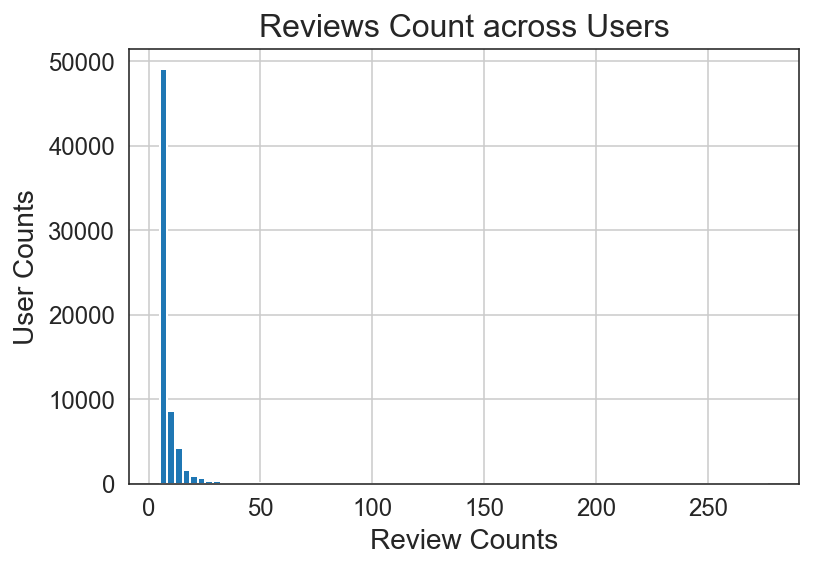

In [9]:
# distribution of user reviews
reviews_count.hist(bins=80)

plt.title('Reviews Count across Users', fontsize=16)
plt.ylabel('User Counts', fontsize=14)
plt.xlabel('Review Counts', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [10]:
# the max no. of reviews from a person in Home & Kitchen: 277 reviews in the past 7 years
# what is the most number of reviews from a person
reviews_count.head()

,reviews_count
A1IU7S4HCK1XK0,277
A25C2M3QF9G7OQ,227
A2ZY49IDE6TY5I,216
A2NYK9KWFMJV4Y,184
A1W415JP5WEAJK,177


In [11]:
# what is the mode?
reviews_mode = stats.mode(df['reviewerID'].value_counts())
print('{} people left {} reviews'.format(reviews_mode[1][0], reviews_mode[0][0]))

22335 people left 5 reviews


In [12]:
df = df.merge(reviews_count, left_on='reviewerID', right_index=True)

In [13]:
df.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewYear,reviews_count
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,2013-10-19,2013,8
6805,APYOBQE6M18AA,B00004R946,Martin Schwartz,"[0, 0]",I've used these percolators in the past and th...,1.0,Classic Electric Percolator After Less than 2 ...,1316822400,2011-09-24,2011,8


In [14]:
# avg no. of reviews per user
print('Mean no. of Reviews per User: ', reviews_count.mean()[0])
print('Median no. of Reviews per User: ', reviews_count.median()[0])

Mean no. of Reviews per User:  8.293600324719254
Median no. of Reviews per User:  6.0


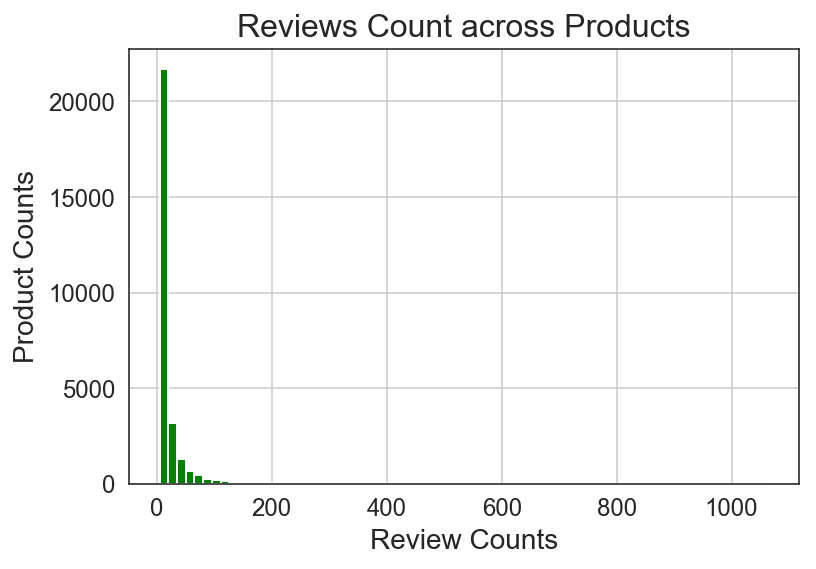

In [15]:
# distribution of reviews across products
reviews_pdts_dist = (df.groupby('asin')[['reviewTime']]
                       .count()
                       .sort_values(by='reviewTime',ascending=False))

reviews_pdts_dist.hist(bins=70, color='g')

plt.title('Reviews Count across Products', fontsize=16)
plt.ylabel('Product Counts', fontsize=14)
plt.xlabel('Review Counts', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [16]:
reviews_pdts_dist.head(10)

,reviewTime
asin,
B00006JSUA,1064
B001N07KUE,921
B00006IUWA,662
B00005B8K5,656
B000QFDNP8,634
B0006HUYGM,612
B00009R66F,608
B00004SPEU,592
B0000CFMZN,572


In [17]:
reviews_pdts_dist.tail()

,reviewTime
asin,
B0015QTC7K,5
B005XHNNNG,5
B005XAM44W,5
B005X8MWZA,5
B001J0TI58,5


In [18]:
# mode for products
reviews_pdts_mode = stats.mode(reviews_pdts_dist)
print('{} products had {} reviews'.format(reviews_pdts_mode[1][0][0], reviews_pdts_mode[0][0][0]))

4340 products had 5 reviews


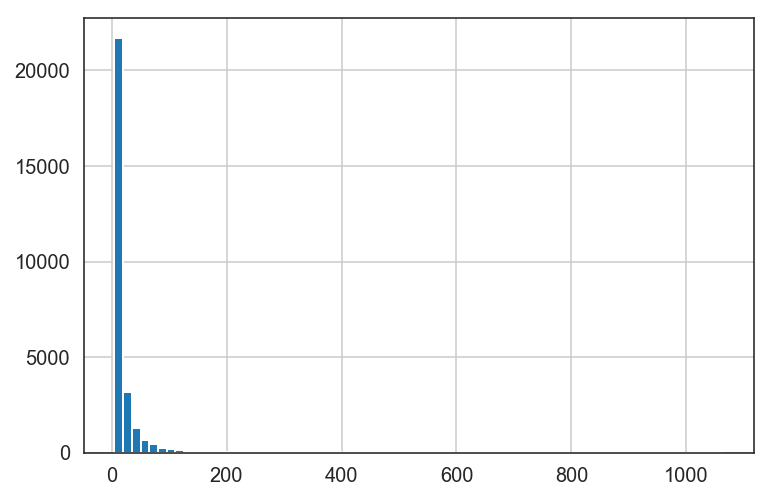

In [19]:
# no. of ratings for each product
df['asin'].value_counts().hist(bins=70)

In [20]:
# check out ratings
ratings = pd.DataFrame(df.groupby('asin')['overall'].mean())
ratings.rename(columns={'overall':'avg_pdt_rtg'}, inplace=True)
ratings['num_ratings'] = df.groupby('asin')['overall'].count()
ratings.head()

,avg_pdt_rtg,num_ratings
asin,,
0615391206,4.454545,11
0689027818,5.000000,5
0912696591,4.548387,93
1223070743,4.250000,8
1567120709,4.062500,16


/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


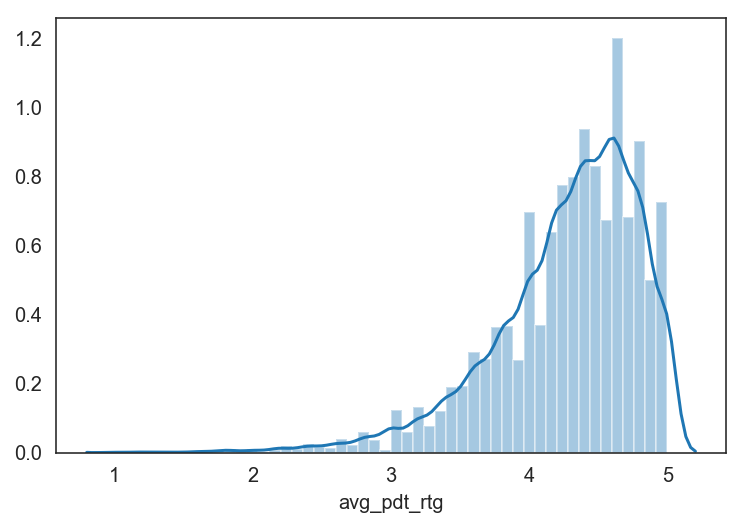

In [21]:
sns.distplot(ratings['avg_pdt_rtg'])

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


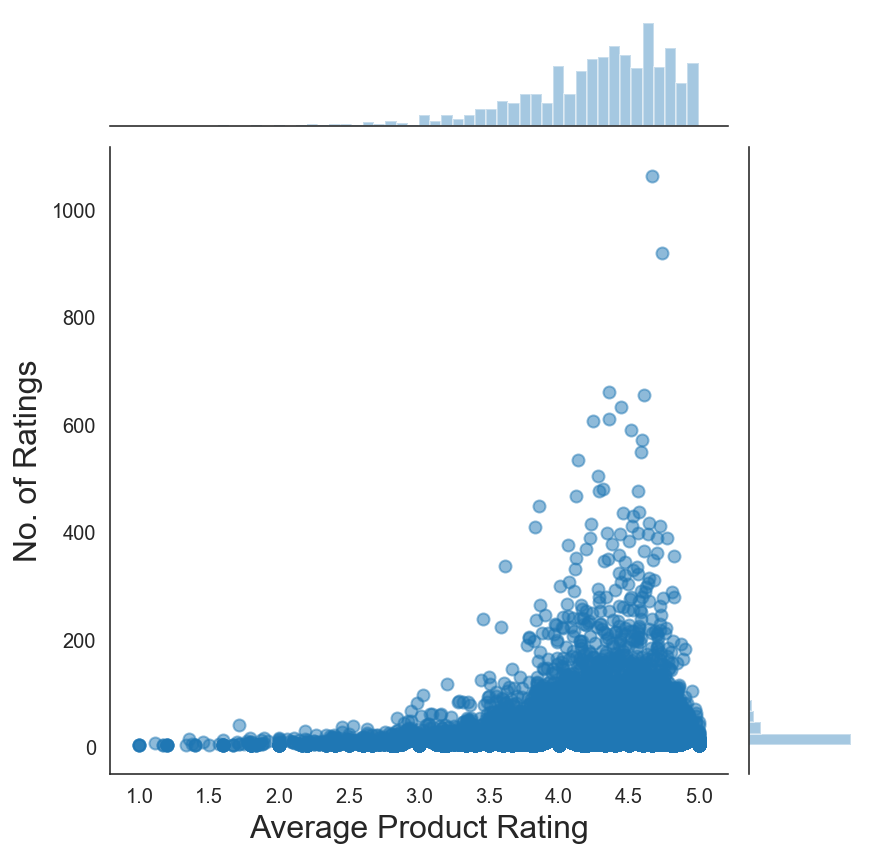

In [22]:
g = sns.jointplot(x='avg_pdt_rtg',y='num_ratings', data=ratings, alpha=0.5)

# JointGrid has a convenience function
g.set_axis_labels('Average Product Rating', 'No. of Ratings', fontsize=16)

plt.show()

#### combining both reviews and metadata

In [23]:
metadata = pd.read_csv('./dataset/home-kitchen-metadata.csv')

In [24]:
metadata.sample(3)

,Unnamed: 0,asin,brand,categories,description,imUrl,price,related,salesRank,title
6492,2733678,B000GDTQX8,NaN,"[['Home & Kitchen', 'Furniture', 'Bedroom Furn...",Soft Sleeper 5.5 has found a way to give you t...,http://ecx.images-amazon.com/images/I/21216WE2...,99.69,"{'also_viewed': ['B0017ZV7J0', 'B006UKK36U', '...",{'Health & Personal Care': 408588},Ortho-pedic Contour Pillow With This Soft Slee...
25238,7300587,B00945S2XO,BELLA,"[['Home & Kitchen', 'Kitchen & Dining', 'Coffe...",NaN,http://ecx.images-amazon.com/images/I/41omsFzz...,28.59,"{'also_viewed': ['B0041GNZSS', 'B00CIWR6AU', '...",{'Kitchen & Dining': 6612},"BELLA 13784 One Scoop One Cup Coffee Maker, Li..."
5329,2535222,B000BGZZ62,NaN,"[['Home & Kitchen', 'Bath', 'Towels', 'Towel S...",Experience these ExceptionalSheets 100-percent...,http://ecx.images-amazon.com/images/I/51yh1C2U...,79.99,"{'also_viewed': ['B00BVZLATS', 'B00BGE2ANE', '...",{'Home &amp; Kitchen': 386022},900 Gram Towel Set Egyptian Cotton Towels by E...


In [25]:
metadata_tojoin = metadata[['asin','brand','categories','description','price','title']]

In [26]:
df_merge = pd.merge(df, metadata_tojoin, how='left', on='asin')

In [27]:
df_merge.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewYear,reviews_count,brand,categories,description,price,title
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,2013-10-19,2013,8,Zoku,"[['Home & Kitchen', 'Kitchen & Dining', 'Kitch...",This book will help you master the art of crea...,17.29,Zoku Quick Pops Recipe Book
1,APYOBQE6M18AA,B00004R946,Martin Schwartz,"[0, 0]",I've used these percolators in the past and th...,1.0,Classic Electric Percolator After Less than 2 ...,1316822400,2011-09-24,2011,8,Farberware,"[['Home & Kitchen', 'Kitchen & Dining', 'Small...","Few things say ""American kitchen"" better than ...",59.99,Farberware FCP280 8-Cup Percolator


In [28]:
ratings_merge = pd.merge(ratings, metadata_tojoin, how='left', right_on='asin', left_index=True)

In [29]:
ratings_merge.head()

,avg_pdt_rtg,num_ratings,asin,brand,categories,description,price,title
0,4.454545,11,0615391206,Zoku,"[['Home & Kitchen', 'Kitchen & Dining', 'Kitch...",This book will help you master the art of crea...,17.29,Zoku Quick Pops Recipe Book
1,5.000000,5,0689027818,NaN,[['Home & Kitchen']],KIDS BOOK ON BUTTERFLIES,473.68,"Good Night, Sweet Butterflies: A Color Dreamland"
2,4.548387,93,0912696591,Wilton,"[['Home & Kitchen', 'Kitchen & Dining', 'Bakew...",This exciting book presents what Wilton has l...,14.26,Wilton Decorating Cakes Book
3,4.250000,8,1223070743,Vandor,"[['Home & Kitchen', 'Kitchen & Dining', 'Stora...","For more than 50-year, Vandor has created hip ...",2.95,Vandor 52423 Star Wars Large Recycled Shopper ...
4,4.062500,16,1567120709,Franklin Electronics,"[['Home & Kitchen', 'Kitchen & Dining', 'Kitch...",Franklin Electronic Publishers Webster's Spell...,27.95,Franklin SPELLING CORRECTOR


In [30]:
df_merge['categories'].nunique()

918

In [31]:
df_merge['categories'].unique()

array(["[['Home & Kitchen', 'Kitchen & Dining', 'Kitchen Utensils & Gadgets', 'Specialty Tools & Gadgets', 'Ice Pop Molds']]",
       "[['Home & Kitchen', 'Kitchen & Dining', 'Small Appliances', 'Coffee, Tea & Espresso Appliances', 'Electric Coffee Percolators']]",
       "[['Home & Kitchen', 'Kitchen & Dining', 'Cookware', 'Grill Pans']]",
       '[[\'Home & Kitchen\', \'Kitchen & Dining\', \'Cookware\', "Chef\'s Pans"]]',
       "[['Home & Kitchen', 'Kitchen & Dining', 'Small Appliances', 'Coffee, Tea & Espresso Appliances', 'Electric Kettles']]",
       "[['Home & Kitchen']]",
       "[['Home & Kitchen', 'Kitchen & Dining', 'Dining & Entertaining', 'Dinnerware Sets']]",
       "[['Home & Kitchen', 'Kitchen & Dining', 'Bakeware', 'Bakeware Sets']]",
       "[['Home & Kitchen', 'Kitchen & Dining', 'Bakeware', 'Baking Tools & Accessories', 'Baking Mats']]",
       "[['Home & Kitchen', 'Furniture', 'Home Entertainment Furniture', 'Audio-Video Shelving']]",
       "[['Home & Kitchen', 'K

In [32]:
len(ratings_merge)

28237

In [33]:
ratings_merge['asin'].nunique()

28237

In [34]:
ratings_merge.head()

,avg_pdt_rtg,num_ratings,asin,brand,categories,description,price,title
0,4.454545,11,0615391206,Zoku,"[['Home & Kitchen', 'Kitchen & Dining', 'Kitch...",This book will help you master the art of crea...,17.29,Zoku Quick Pops Recipe Book
1,5.000000,5,0689027818,NaN,[['Home & Kitchen']],KIDS BOOK ON BUTTERFLIES,473.68,"Good Night, Sweet Butterflies: A Color Dreamland"
2,4.548387,93,0912696591,Wilton,"[['Home & Kitchen', 'Kitchen & Dining', 'Bakew...",This exciting book presents what Wilton has l...,14.26,Wilton Decorating Cakes Book
3,4.250000,8,1223070743,Vandor,"[['Home & Kitchen', 'Kitchen & Dining', 'Stora...","For more than 50-year, Vandor has created hip ...",2.95,Vandor 52423 Star Wars Large Recycled Shopper ...
4,4.062500,16,1567120709,Franklin Electronics,"[['Home & Kitchen', 'Kitchen & Dining', 'Kitch...",Franklin Electronic Publishers Webster's Spell...,27.95,Franklin SPELLING CORRECTOR


In [35]:
ratings_merge['categories'][0]

"[['Home & Kitchen', 'Kitchen & Dining', 'Kitchen Utensils & Gadgets', 'Specialty Tools & Gadgets', 'Ice Pop Molds']]"

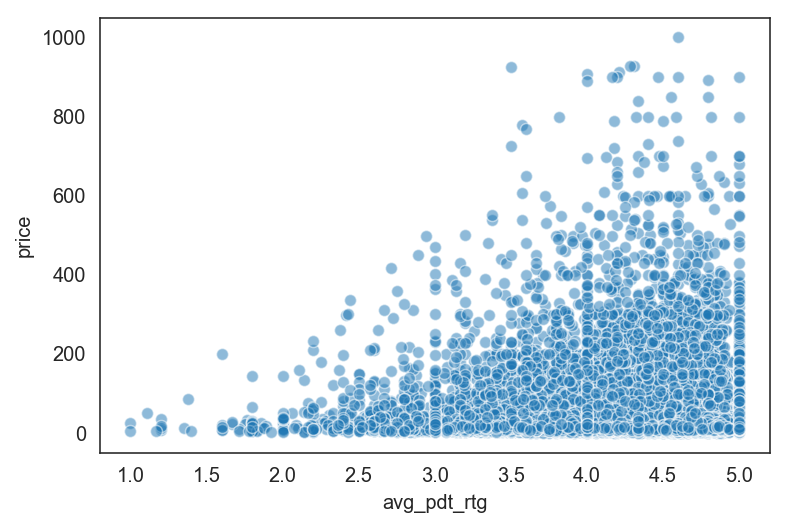

In [36]:
# distribution of price and product rating
sns.scatterplot(x='avg_pdt_rtg', y='price', data=ratings_merge,alpha=0.5)

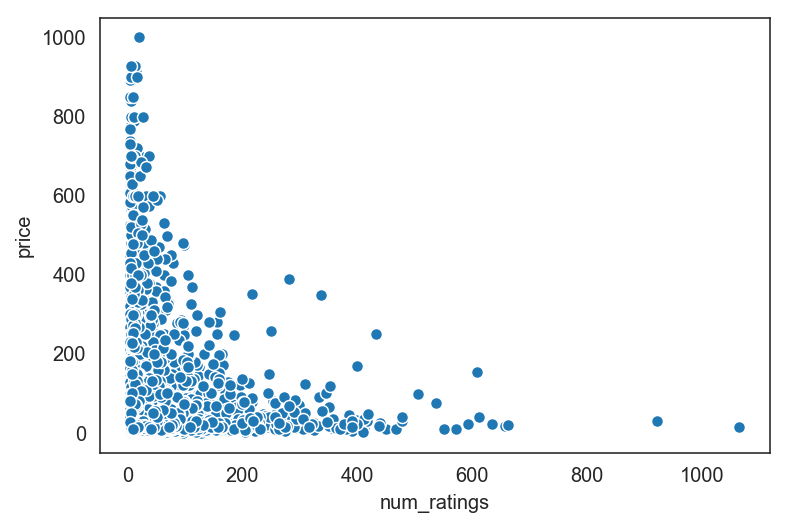

In [37]:
# price vs num of ratings
sns.scatterplot(x='num_ratings', y='price', data=ratings_merge)

In [38]:
# top 10 products by rating and no. of reviews
top_10_pdts = (ratings_merge.sort_values(by=['avg_pdt_rtg','num_ratings'], ascending=False)
                            .head(10))

top_10_pdts[['asin','title','brand','avg_pdt_rtg','num_ratings']]

,asin,title,brand,avg_pdt_rtg,num_ratings
28159,B00K4S1L1K,Nonstick Silicone Baking Mat eliminates burnt ...,NaN,5.0,48
28115,B00JOUZOTY,Dough Blender - Pastry Blender - Stainless Ste...,NaN,5.0,42
27881,B00HQCJP88,3 Silicone Coated Fiberglass Baking Mats - SET...,NaN,5.0,32
28142,B00JWXSPAS,Basily Wine Aerator --- BREATHES wine straight...,NaN,5.0,30
17918,B003U5UYPS,"Madesmart Turntable, 10-Inch Diameter",Made Smart,5.0,27
28198,B00KI2RQHU,Best Nut Milk Bag - Reusable 12&quot; x 10&quo...,NaN,5.0,27
9069,B000SQFGRS,LEM Products Jerky Cannon,LEM,5.0,24
27989,B00ILMJVLI,Dish Towels Flour Sack Are 30&quot; x 30&quot;...,NaN,5.0,24
27694,B00GLF65SO,Confetti Colors Silicone Baking Cups :: Set of...,NaN,5.0,23
1282,B00006484E,Donvier 837409W 1-Quart Ice Cream Maker,Donvier,5.0,20


In [39]:
# bottom 10 products
bottom_10_pdts = (ratings_merge.sort_values(by=['avg_pdt_rtg', 'num_ratings'], 
                                            ascending=[True, False])
                               .head(10))
bottom_10_pdts[['asin','title','brand','avg_pdt_rtg','num_ratings']]

,asin,title,brand,avg_pdt_rtg,num_ratings
8519,B000PQXIOO,Zorbeez Ultra Absorbent Towels,Zorbeez,1.000000,6
3810,B0002Y5XL0,KitchenAid KCM511OB 10-Cup Programmable Coffee...,NaN,1.000000,5
4932,B0009VIFQQ,Hoover Savvy U8174-900 Bagless Upright Vacuum,NaN,1.000000,5
13851,B0026LOWIW,"Sterilite 72320024 Ice Cube Tray, Blue",STERILITE,1.000000,5
1848,B0000AFQ5S,Black &amp; Decker GG200 Electric Cheese and C...,NaN,1.111111,9
861,B00005B6YL,Toastmaster T2040WC 4-Slice Dual-Control Toaster,NaN,1.166667,6
26127,B00B2IWUHA,Ice Cream Magic Personal Ice Cream Maker (ASSO...,Idea Village Products,1.166667,6
1593,B00008DHPT,KitchenAid multi Slicer,KitchenAid,1.200000,5
2585,B0000TQGUE,"Space Bag BRS-5400ZG Vacuum-Seal Storage Bag, ...",Space Bag,1.200000,5
3148,B0001OHHDS,Tide Buzz Stain Remover Powered by Black &amp;...,NaN,1.200000,5


In [40]:
# top products all
ratings_merge.sort_values(by='num_ratings', ascending=False).head()

,avg_pdt_rtg,num_ratings,asin,brand,categories,description,price,title
1469,4.664474,1064,B00006JSUA,Lodge,"[['Home & Kitchen', 'Kitchen & Dining', 'Cookw...",NaN,15.92,"Lodge L8SK3 Pre-Seasoned Cast-Iron Skillet, 10..."
12999,4.739414,921,B001N07KUE,EatSmart,"[['Home & Kitchen', 'Kitchen & Dining', 'Kitch...",Overview- The EatSmart Precision Pro Digital K...,29.50,"EatSmart Precision Pro Digital Kitchen Scale, ..."
1420,4.359517,662,B00006IUWA,Presto,"[['Home & Kitchen', 'Kitchen & Dining', 'Small...",Plug in Presto&#x2019;s PopLite and the party ...,19.85,"Presto 04820 PopLite Hot Air Popper, White"
871,4.612805,656,B00005B8K5,Pyrex,"[['Home & Kitchen', 'Kitchen & Dining', 'Bakew...",Transporting foods for lunches and picnics and...,17.50,"Pyrex Storage 10-Piece Set, Clear with Blue Lids"
8646,4.441640,634,B000QFDNP8,Contigo,"[['Home & Kitchen', 'Kitchen & Dining', 'Dinin...",NaN,22.48,Contigo AUTOSEAL Stainless Steel Vacuum Insula...


In [41]:
# top products
ratings.sort_values(by=['avg_pdt_rtg','num_ratings'],ascending=[False,False]).head(10)

,avg_pdt_rtg,num_ratings
asin,,
B00K4S1L1K,5.0,48
B00JOUZOTY,5.0,42
B00HQCJP88,5.0,32
B00JWXSPAS,5.0,30
B003U5UYPS,5.0,27
B00KI2RQHU,5.0,27
B000SQFGRS,5.0,24
B00ILMJVLI,5.0,24
B00GLF65SO,5.0,23


In [42]:
ratings.sort_values(by=['avg_pdt_rtg','num_ratings'],ascending=[False,False]).head(10).index

Index(['B00K4S1L1K', 'B00JOUZOTY', 'B00HQCJP88', 'B00JWXSPAS', 'B003U5UYPS',
       'B00KI2RQHU', 'B000SQFGRS', 'B00ILMJVLI', 'B00GLF65SO', 'B00006484E'],
      dtype='object', name='asin')

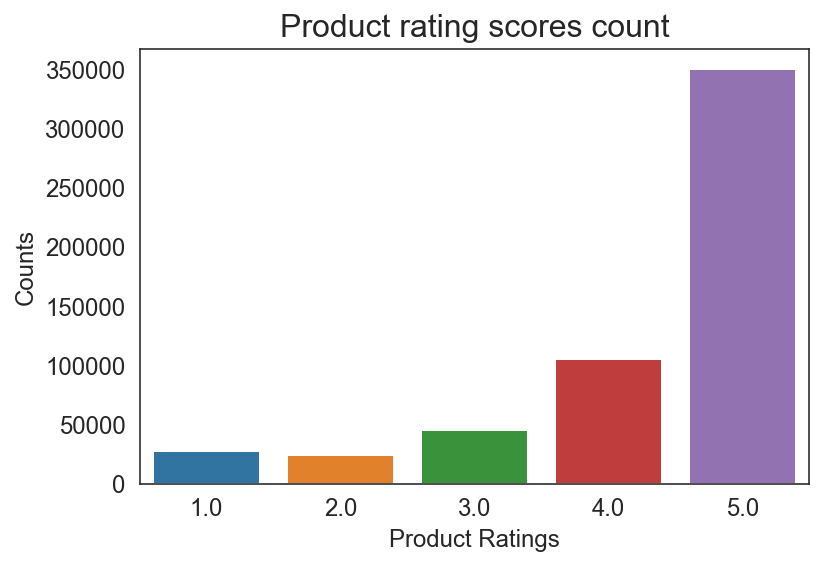

In [43]:
fig, ax = plt.subplots()

sns.countplot(df['overall'])
plt.title('Product rating scores count', fontsize=16)
plt.xlabel('Product Ratings', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

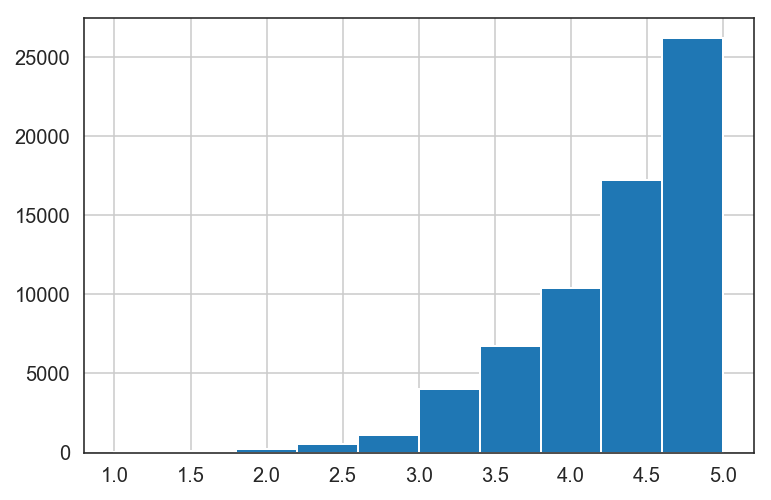

In [44]:
# average user rating
df.groupby('reviewerID')['overall'].mean().hist()

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


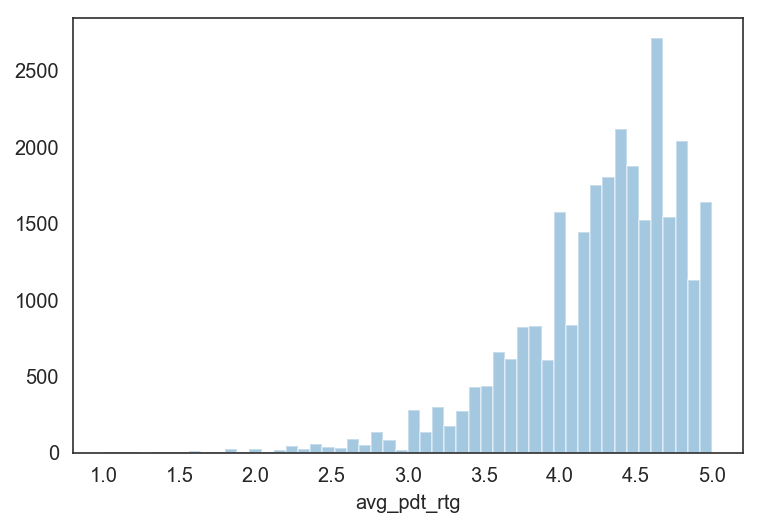

In [45]:
# is there a difference in distribution of mean user and mean product ratings?
sns.distplot(ratings['avg_pdt_rtg'],kde=False) # product ratings

In [46]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime', 'reviewYear',
       'reviews_count'],
      dtype='object')

In [47]:
ratings_byuser = df.groupby('reviewerID')[['overall']].mean()
ratings_byuser.rename(columns={'overall':'avg_user_rtg'},inplace=True)

In [48]:
ratings_byuser['num_ratings'] = df.groupby('reviewerID')['overall'].count()

In [49]:
ratings_byuser.sort_values(by=['avg_user_rtg','num_ratings'], ascending=False).head()

,avg_user_rtg,num_ratings
reviewerID,,
A30WOXPI820KFJ,5.0,58
A3PCNEGJJLFB46,5.0,54
A1CSXI7MKL6UKR,5.0,51
ARG3VM9YC306W,5.0,51
A345N1VP5CBPJU,5.0,50


/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


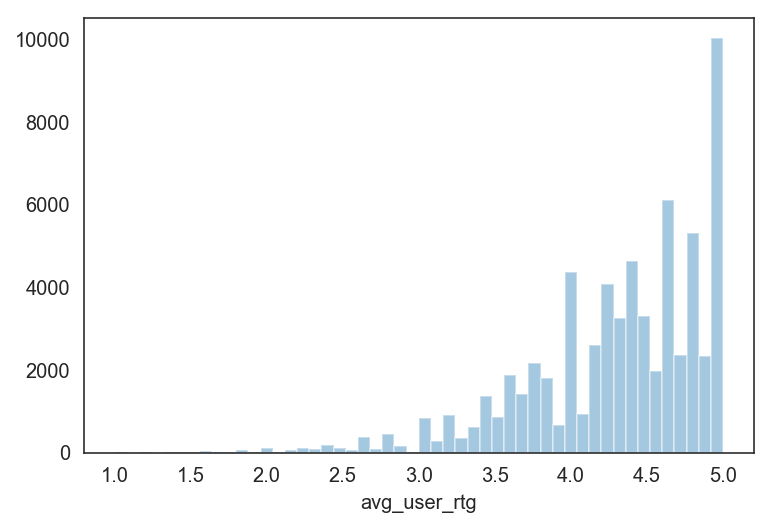

In [50]:
# distribution by user ratings
sns.distplot(ratings_byuser['avg_user_rtg'],kde=False)

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


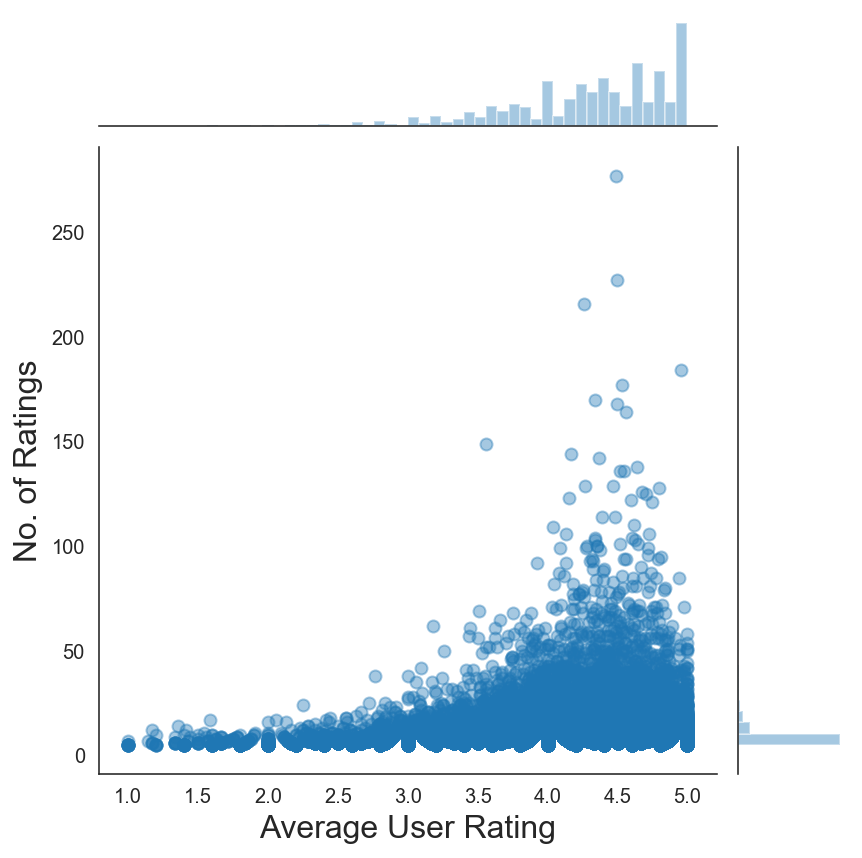

In [51]:
# Do frequent raters rate differently?
g = sns.jointplot(x='avg_user_rtg', y='num_ratings', data=ratings_byuser, alpha=0.4)
g.set_axis_labels('Average User Rating', 'No. of Ratings', fontsize=16)

plt.show()

In [52]:
# relationship between review length and ratings
# do longer reviews mean higher ratings? or just means more extreme ratings (v good or v bad)

In [53]:
df['review_len'] = df['reviewText'].apply(lambda x: len(x.split()))

In [54]:
df.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewYear,reviews_count,review_len
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,2013-10-19,2013,8,30
6805,APYOBQE6M18AA,B00004R946,Martin Schwartz,"[0, 0]",I've used these percolators in the past and th...,1.0,Classic Electric Percolator After Less than 2 ...,1316822400,2011-09-24,2011,8,77


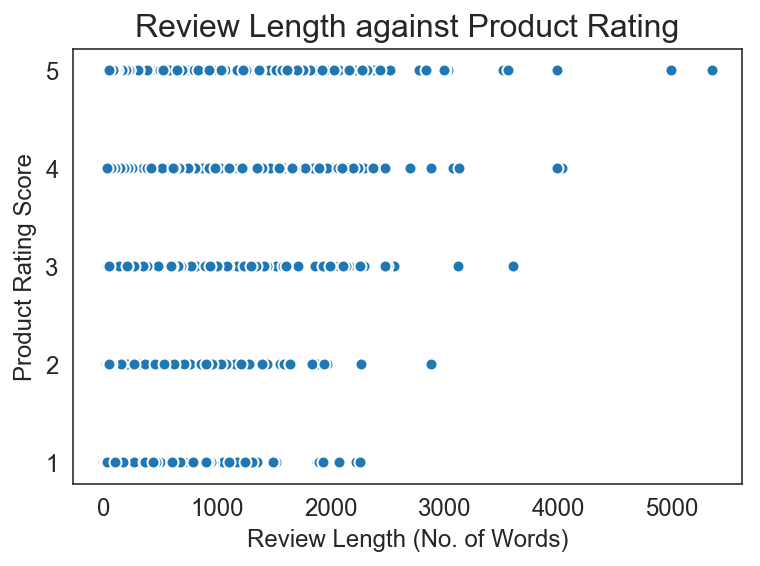

In [55]:
plt.scatter(df['review_len'], df['overall'], edgecolors='w')

plt.title('Review Length against Product Rating', fontsize=16)
plt.xlabel('Review Length (No. of Words)', fontsize=12)
plt.ylabel('Product Rating Score', fontsize=12)
plt.yticks(np.arange(1,6), fontsize=12)
plt.xticks(fontsize=12)

plt.show()

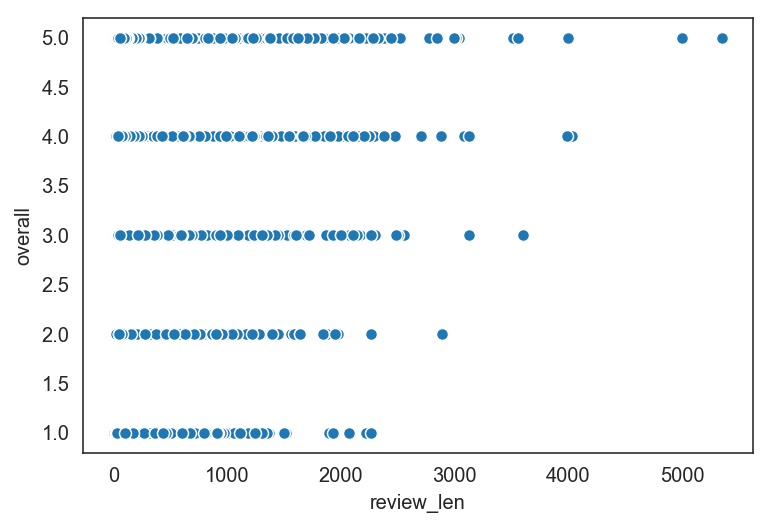

In [56]:
sns.scatterplot(x='review_len', y='overall', data=df)

In [57]:
df[df['review_len']>4000]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewYear,reviews_count,review_len
50328,AX9FIZX89LNFQ,B00009ADDR,"C.V. May ""Searching for The Good Stuff""","[0, 0]","""One chews coffee beans while gargling 200 F w...",5.0,"6 YEARS AND OVER 3,500 BREWS WITH A FRIELING: ...",1388448000,2013-12-31,2013,78,4998
424318,AX9FIZX89LNFQ,B004XGBLNC,"C.V. May ""Searching for The Good Stuff""","[0, 0]","""One chews coffee beans while gargling 200 F w...",5.0,"SIX YEARS WITH A FRIELING: 3,500 Brews Later (...",1398297600,2014-04-24,2014,78,4998
439942,AX9FIZX89LNFQ,B005FCE72U,"C.V. May ""Searching for The Good Stuff""","[4, 4]","""One chews coffee beans while gargling 200 F w...",5.0,"SIX YEARS WITH A FRIELING: 3,500 Brews Later (...",1334102400,2012-04-11,2012,78,4998
277251,AMUNDUVA1VUB9,B001L7OIVI,Phil Rosenbach,"[398, 408]",I spent over a year researching a wide variety...,5.0,"My Research Paid Off. A Very, VERY Lengthy Re...",1349308800,2012-10-04,2012,8,5354
497633,A35Y0RSU09ANEN,B008TUWP24,Peter B. Nelson,"[27, 29]",OVERVIEW: As a long-time coffee snob I couldn'...,4.0,Face-off: Rancilio Silvia vs. Nespresso Pixie ...,1357516800,2013-01-07,2013,16,4035


In [ ]:
def categories_to_columns(row, cat_level):
        try:
            return row[cat_level]
        except IndexError:
            return np.nan
        
    def get_product_id(product_name):
        return metadata[metadata['title']==product_name]['asin'].values[0]
    
    rec_cat = pd.DataFrame([[item, category_lookup[item]] for item in list_of_products], 
                           columns=['Product Names', 'Category Path'])
    
    rec_cat['Category Path'] = rec_cat['Category Path'].apply(
        lambda x: [cat.strip() for cat in re.sub('[\[\]\'\"]', '', x).split(',')])
    
    rec_cat['cat_1'] = rec_cat['Category Path'].apply(lambda x: categories_to_columns(x,1))

    for i in range(1, 7):
        rec_cat['cat_'+str(i)] = rec_cat['Category Path'].apply(lambda x: categories_to_columns(x, i-1))
    
    rec_cat = rec_cat[['Product Names', 'cat_2', 'cat_3', 'cat_4']].sort_values(by=['cat_2','cat_3','cat_4'])

In [61]:
# clean up categories column

In [59]:
import re

In [60]:
ratings_merge['categories'] = ratings_merge['categories'].apply(lambda x: [cat.strip() for cat in re.sub('[\[\]\'\"]', '', x).split(',')])

In [62]:
ratings_merge['category_levels'] = ratings_merge['categories'].apply(lambda x: len(x))

In [63]:
ratings_merge[ratings_merge['category_levels']==16]['categories'].values

array([], dtype=object)

In [65]:
ratings_merge['categories'][2][0]

'Home & Kitchen'

In [66]:
def categories_to_columns(row, cat_level):
    try:
        return row[cat_level]
    except IndexError:
        return np.nan

In [67]:
ratings_merge['cat_1'] = ratings_merge['categories'].apply(lambda x: categories_to_columns(x,1))

In [68]:
ratings_merge.head(2)

,avg_pdt_rtg,num_ratings,asin,brand,categories,description,price,title,category_levels,cat_1
0,4.454545,11,0615391206,Zoku,"[Home & Kitchen, Kitchen & Dining, Kitchen Ute...",This book will help you master the art of crea...,17.29,Zoku Quick Pops Recipe Book,5,Kitchen & Dining
1,5.000000,5,0689027818,NaN,[Home & Kitchen],KIDS BOOK ON BUTTERFLIES,473.68,"Good Night, Sweet Butterflies: A Color Dreamland",1,NaN


In [69]:
for i in range(1, 7):
    ratings_merge['cat_'+str(i)] = ratings_merge['categories'].apply(lambda x: categories_to_columns(x, i-1))

In [70]:
# merge category breakdowns with df_merge
df_merge = df_merge.merge(ratings_merge[['asin','cat_1','cat_2','cat_3','cat_4','cat_5','cat_6']],
                          how='left',
                          on='asin')

In [71]:
# what are people buying most in this dataset
df_merge['cat_1'].value_counts()

Home & Kitchen              551558
Automotive                      69
Health & Personal Care          49
Tools & Home Improvement         6
Name: cat_1, dtype: int64

In [80]:
df_merge['cat_4'].unique()

array(['Specialty Tools & Gadgets', 'Coffee', 'Grill Pans', 'Chefs Pans',
       nan, 'Dinnerware Sets', 'Bakeware Sets',
       'Baking Tools & Accessories', 'Audio-Video Shelving',
       'Food Processors', 'Mixers', 'Saucepans', 'Steamers',
       'Pressure Cookers', 'Tool & Gadget Sets',
       'Seasoning & Spice Tools', 'Graters', 'Specialty Appliances',
       'Tea & Espresso', 'Reusable Grocery Bags', 'Skillets',
       'Coffee & Espresso Machine Parts & Accessories',
       'Thermometers & Timers', 'Trash Cans', 'Cookware Accessories',
       'Cheese Tools', 'Bread Machines', 'Potholders & Oven Mitts',
       'Griddles', 'Bathtub Accessories', 'Cake Pans', 'Juicers',
       'Kitchen Rugs & Mats', 'Pitcher Water Filters', 'Upright Vacuums',
       'Replacement Water Filters', 'Flatware', 'Household Fans',
       'Slow Cookers', 'Blenders', 'Ice Cream Machines', 'Wine Racks',
       'Small Pastry Molds', 'Space Heaters & Accessories', 'Tables',
       'Steam Mops', 'Fruit & Veget

In [72]:
df_merge[df_merge['cat_1']!='Home & Kitchen']

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewYear,...,categories,description,price,title,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6
8509,A3LPL35P7FH78Y,B000OTCRPI,Marie Daniels,"[0, 0]",These size 4 S-Biners are a first for me. I re...,5.0,Pretty cool.,1383523200,2013-11-04,2013,...,"[['Tools & Home Improvement', 'Power & Hand To...",NaN,2.94,S-biner #4 Carabiner,Tools & Home Improvement,Power & Hand Tools,Hand Tools,Flashlights,Key Chain Flashlights,Home & Kitchen
8560,A2R6RA8FRBS608,B0014COKYU,Matthew G. Sherwin,"[8, 12]",Spray Nine has been a staple in my home for ov...,5.0,Excellent cleanser...,1185494400,2007-07-27,2007,...,"[['Health & Personal Care', 'Household Supplie...",NaN,4.41,NaN,Health & Personal Care,Household Supplies,Household Cleaning,All-Purpose Cleaners,Home & Kitchen,Vacuums & Floor Care
16638,A1OBJYK6JH67AF,B0014COKYU,Amazon Customer,"[0, 1]",My maintenance guy from my building recommende...,5.0,Cleans Anything,1359590400,2013-01-31,2013,...,"[['Health & Personal Care', 'Household Supplie...",NaN,4.41,NaN,Health & Personal Care,Household Supplies,Household Cleaning,All-Purpose Cleaners,Home & Kitchen,Vacuums & Floor Care
20219,A28621TSIR5EOG,B00068GEJM,"Walk Around ""Osprey""","[1, 1]",Worked great getting off the grime from the al...,5.0,Mothers 05101 Mag and aluminum polish,1382486400,2013-10-23,2013,...,"[['Automotive', 'Car Care', 'Exterior Care', '...",Mothers Mag and Aluminum Polish - 5 ounce feat...,6.49,NaN,Automotive,Car Care,Exterior Care,Car Polishes & Waxes,Chrome & Metal Polishes,Metal Polishes
21876,A2582KMXLK2P06,B00068GEJM,B. E Jackson,"[11, 14]",You can clean any kind of metal with this prod...,5.0,metal polish done right,1153267200,2006-07-19,2006,...,"[['Automotive', 'Car Care', 'Exterior Care', '...",Mothers Mag and Aluminum Polish - 5 ounce feat...,6.49,NaN,Automotive,Car Care,Exterior Care,Car Polishes & Waxes,Chrome & Metal Polishes,Metal Polishes
25664,A1MWD531YBV3BY,B00192JFYA,"D. Archer ""deb""","[0, 0]",Pretty glamping wine glasses. I think I'll loo...,5.0,Glamping,1396742400,2014-04-06,2014,...,"[['Automotive', 'RV Parts & Accessories', 'Fur...",Don't worry about broken glassware anymore wit...,11.48,NaN,Automotive,RV Parts & Accessories,Furnishings,Bath,Laundry & Kitchen,Home & Kitchen
28305,A2RGEQ4EOILD9Q,B00192JFYA,"KSJ ""KJ""","[0, 0]",My husband loves the handling of this unbreaka...,3.0,One of ours got cloudy,1394496000,2014-03-11,2014,...,"[['Automotive', 'RV Parts & Accessories', 'Fur...",Don't worry about broken glassware anymore wit...,11.48,NaN,Automotive,RV Parts & Accessories,Furnishings,Bath,Laundry & Kitchen,Home & Kitchen
31740,A376OJHLE6SU9Q,B00JGM7Z5Q,M. Wolf,"[0, 0]","Thin,light weightDurableBeautifulThis is a MUC...",5.0,I love this for my home kitchen counter top,1405555200,2014-07-17,2014,...,"[['Automotive', 'RV Parts & Accessories', 'Fur...",Camco's Bamboo Stove Top Work Surface is made ...,65.89,NaN,Automotive,RV Parts & Accessories,Furnishings,Bath,Laundry & Kitchen,Home & Kitchen
32546,A3J3OCM6PPWNRY,B00068GEJM,"Dinakar Sarma ""Dino""","[1, 1]",Because it really is magic. A tiny little dab ...,5.0,They should call it magIC polish,1298332800,2011-02-22,2011,...,"[['Automotive', 'Car Care', 'Exterior Care', '...",Mothers Mag and Aluminum Polish - 5 ounce feat...,6.49,NaN,Automotive,Car Care,Exterior Care,Car Polishes & Waxes,Chrome & Metal Polishes,Metal Polishes
37705,AOCY439A1FN4X,B00068GEJM,TheGuy,"[0, 0]",I shined some stainless up after progressive g...,5.0,shiny,1393286400,2014-02-25,2014,...,"[['Automotive', 'Car Care', 'Exterior Care', '...",Mothers Mag and Aluminum Polish - 5 ounce feat...,6.49,NaN,Automotive,Car Care,Exterior Care,Car Polishes & Waxes,Chrome & Metal Polishes,Metal Polishes


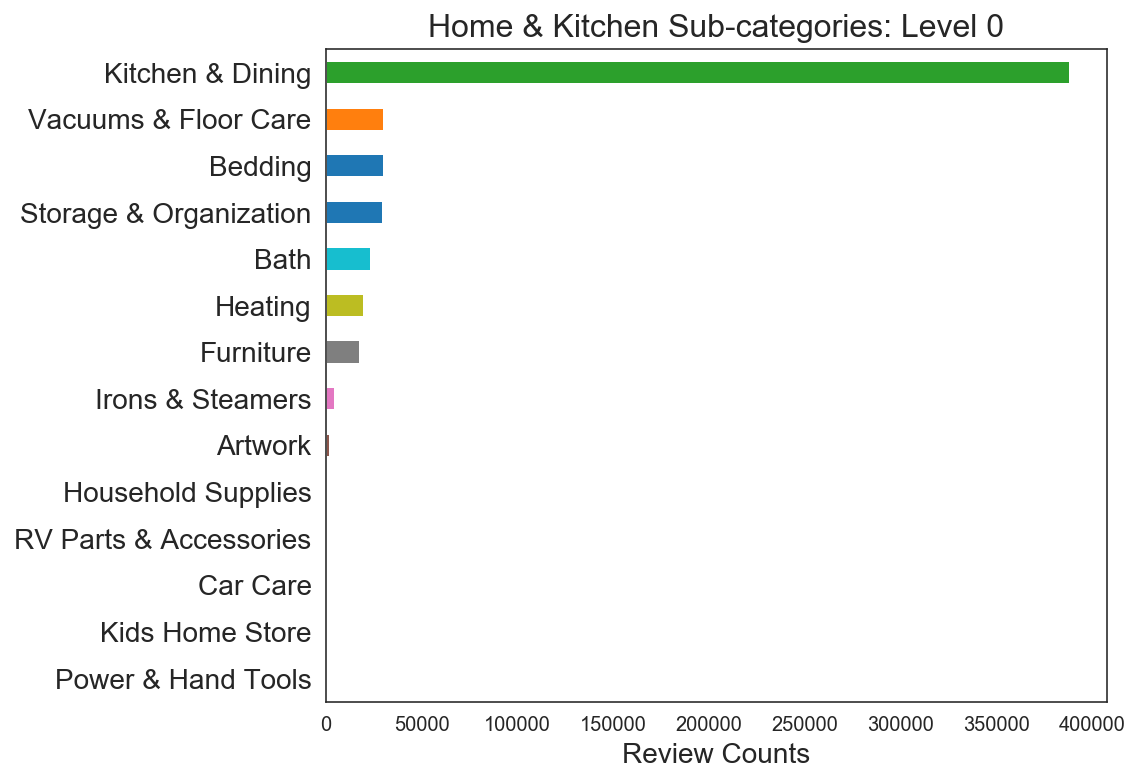

In [75]:
plt.figure(figsize=(7,6))

df_merge['cat_2'].value_counts().sort_values().plot(kind='barh')
plt.title('Home & Kitchen Sub-categories: Level 0', fontsize=16)
plt.xlabel('Review Counts', fontsize=14)
plt.yticks(fontsize=14)
plt.show()

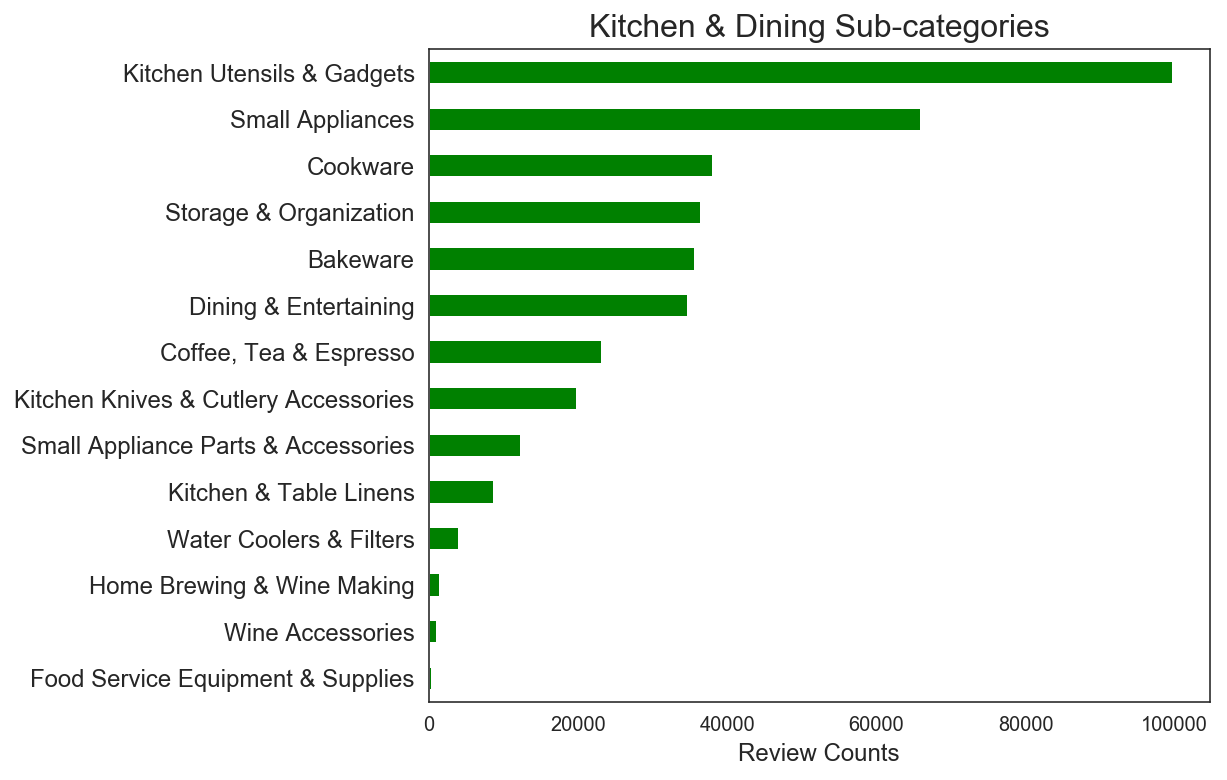

In [74]:
plt.figure(figsize=(7,6))

(df_merge[df_merge['cat_2']=='Kitchen & Dining']['cat_3'].value_counts()
                                                         .sort_values()
                                                         .plot(kind='barh',color='g'))

plt.title('Kitchen & Dining Sub-categories', fontsize=16)
plt.xlabel('Review Counts', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

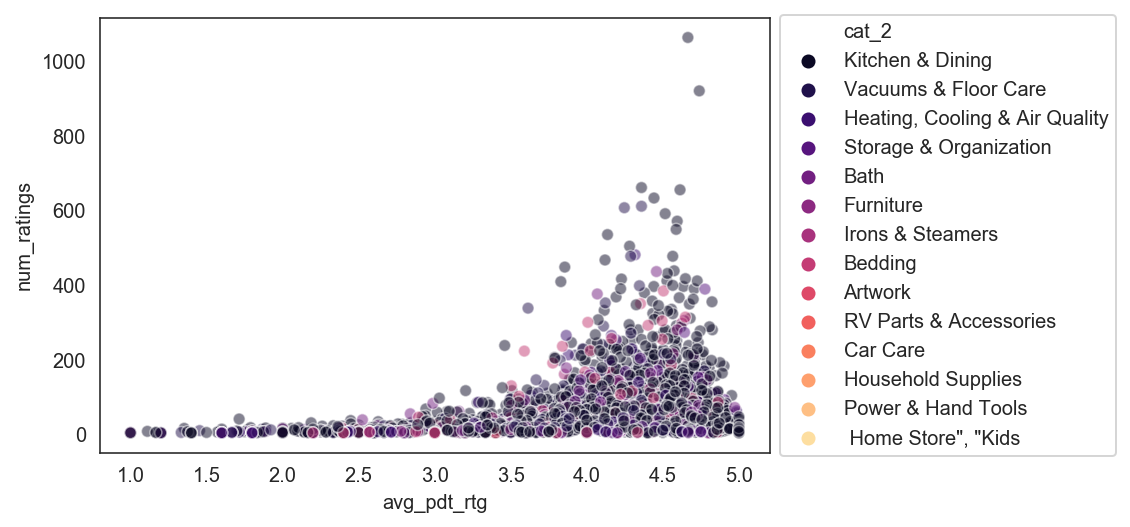

In [75]:
# are certain categories more well received?
# is fail
plt.figure()
sns.scatterplot(x='avg_pdt_rtg', y='num_ratings', data=ratings_merge, hue='cat_2',alpha=0.5,
                palette='magma')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

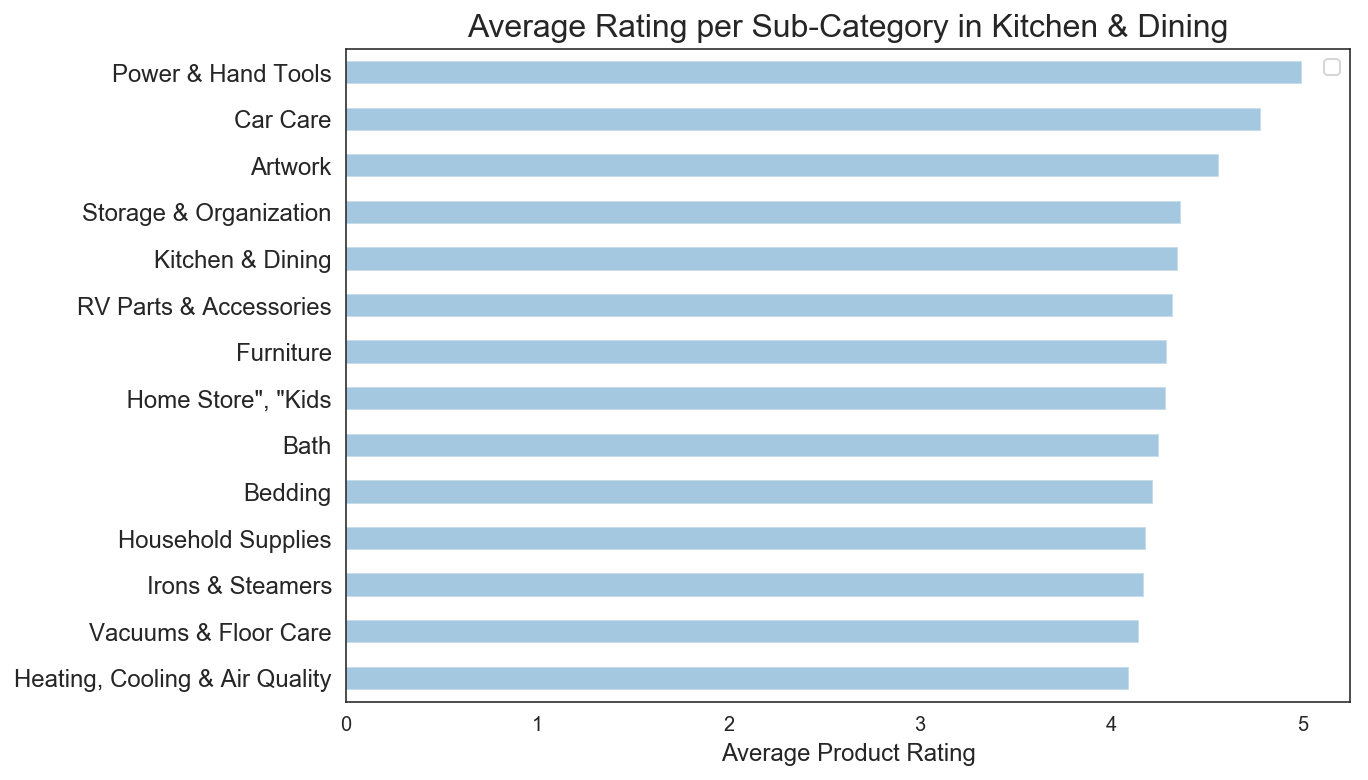

In [76]:
# average rating per product category (cat 2)

(df_merge.groupby('cat_2')[['overall']].mean()
                                       .sort_values(by='overall')
                                       .plot(kind='barh', alpha=0.4, figsize=(9,6)))

plt.title('Average Rating per Sub-Category in Kitchen & Dining', fontsize=16)
plt.xlabel('Average Product Rating', fontsize=12)
plt.ylabel('')
plt.yticks(fontsize=12)
plt.legend('')

plt.show()

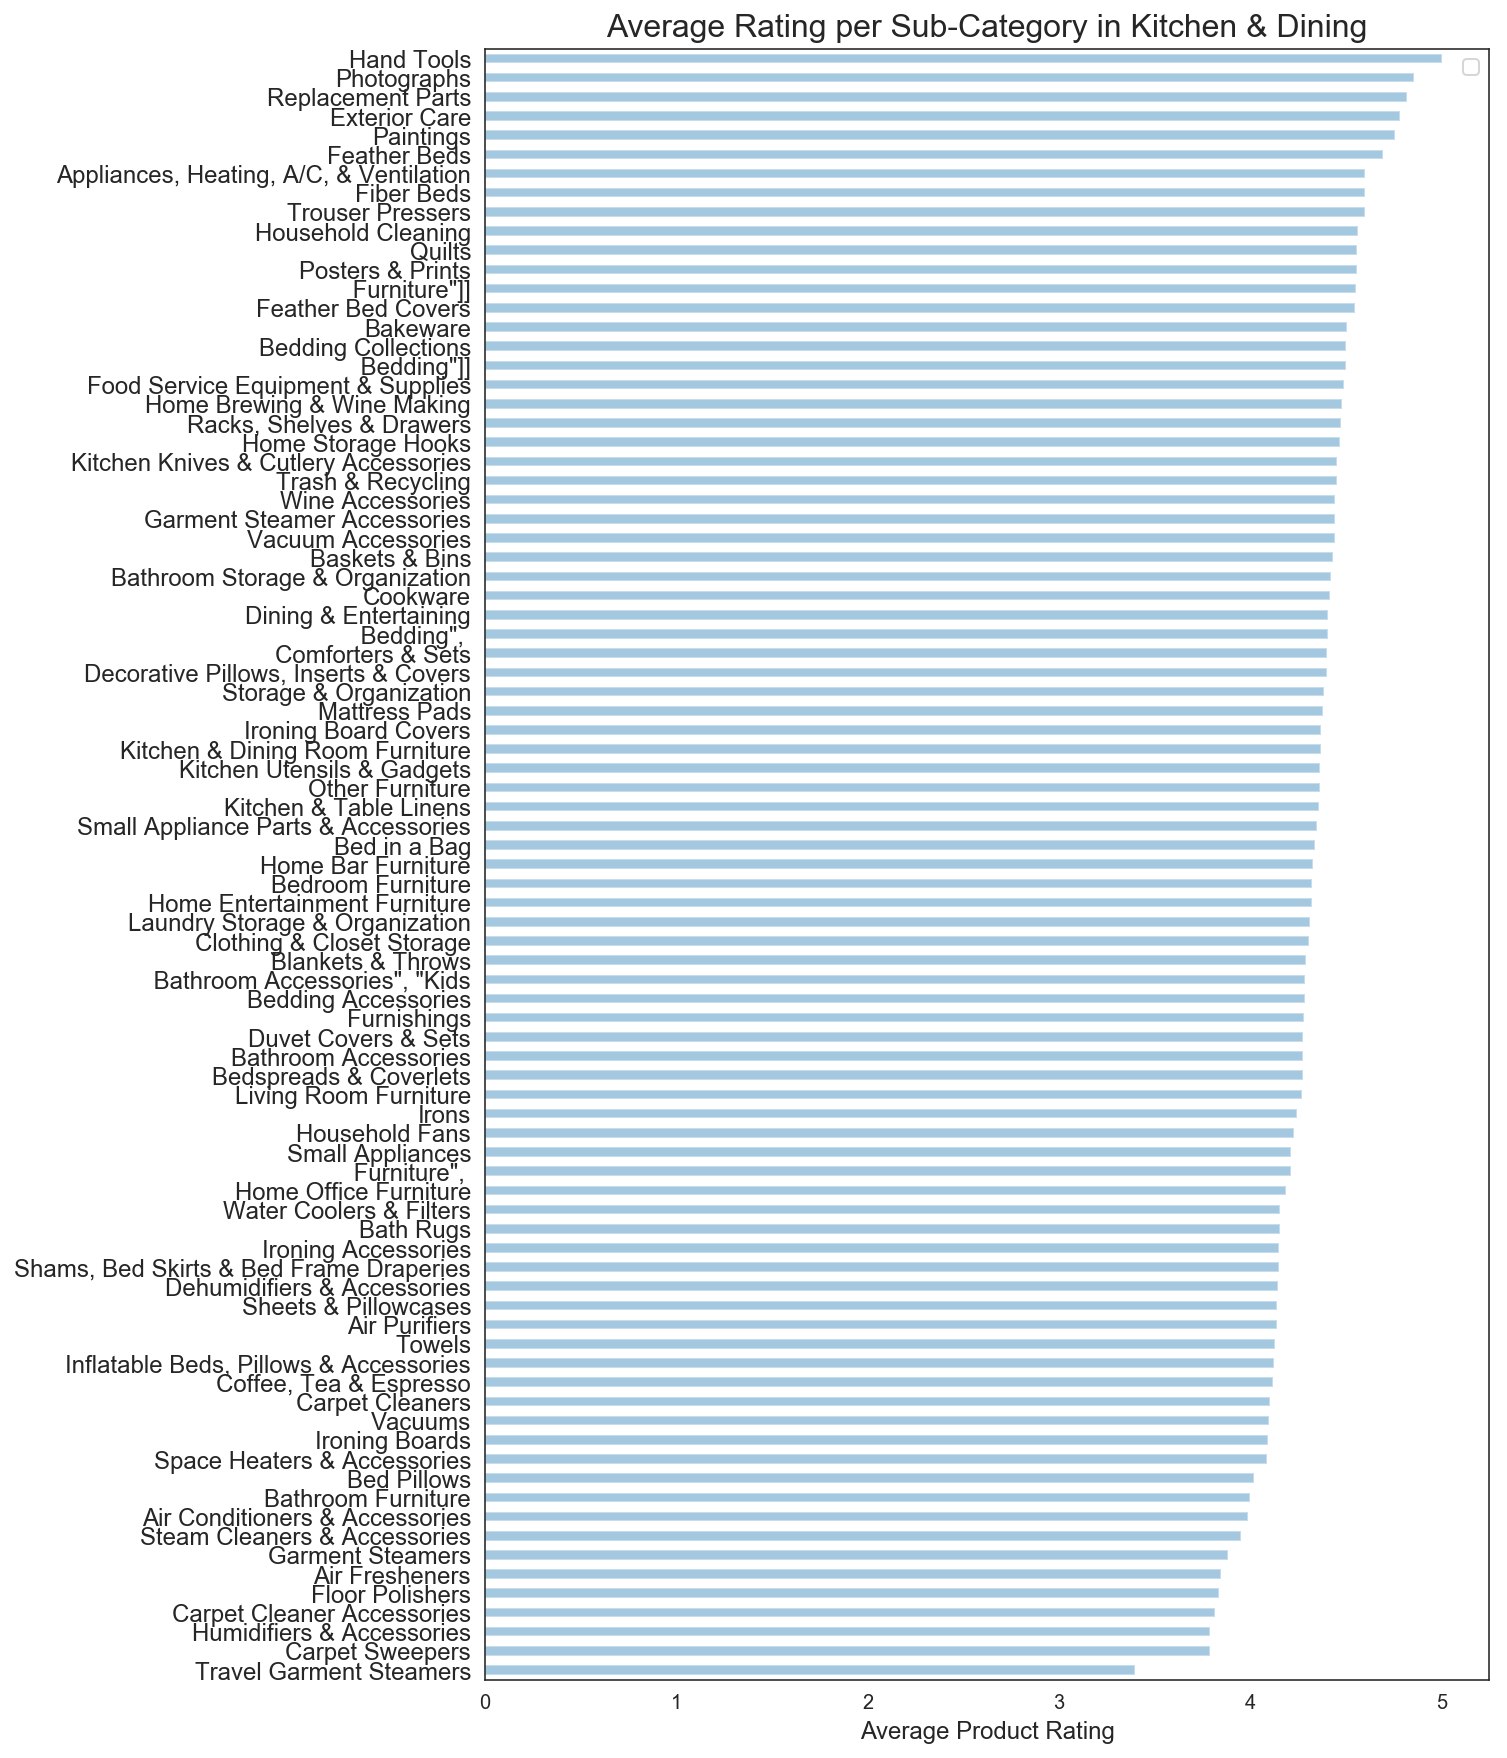

In [77]:
# average rating per product category (cat 3)


(df_merge.groupby('cat_3')[['overall']].mean()
                                       .sort_values(by='overall')
                                       .plot(kind='barh', alpha=0.4, figsize=(9,15)))

plt.title('Average Rating per Sub-Category in Kitchen & Dining', fontsize=16)
plt.xlabel('Average Product Rating', fontsize=12)
plt.ylabel('')
plt.yticks(fontsize=12)
plt.legend('')

plt.show()

In [78]:
df_merge.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewYear,...,categories,description,price,title,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,2013-10-19,2013,...,"[['Home & Kitchen', 'Kitchen & Dining', 'Kitch...",This book will help you master the art of crea...,17.29,Zoku Quick Pops Recipe Book,Home & Kitchen,Kitchen & Dining,Kitchen Utensils & Gadgets,Specialty Tools & Gadgets,Ice Pop Molds,NaN
1,APYOBQE6M18AA,B00004R946,Martin Schwartz,"[0, 0]",I've used these percolators in the past and th...,1.0,Classic Electric Percolator After Less than 2 ...,1316822400,2011-09-24,2011,...,"[['Home & Kitchen', 'Kitchen & Dining', 'Small...","Few things say ""American kitchen"" better than ...",59.99,Farberware FCP280 8-Cup Percolator,Home & Kitchen,Kitchen & Dining,Small Appliances,"Coffee, Tea & Espresso Appliances",Electric Coffee Percolators,NaN
2,APYOBQE6M18AA,B0000CF66W,Martin Schwartz,"[0, 0]",I bought this pan along with another Lodge pan...,5.0,Excellent Pan,1382140800,2013-10-19,2013,...,"[['Home & Kitchen', 'Kitchen & Dining', 'Cookw...",The Lodge Cast Iron 10.25-inch square Grill Pa...,21.49,Lodge L8SGP3 Pre-Seasoned Cast-Iron Square Gri...,Home & Kitchen,Kitchen & Dining,Cookware,Grill Pans,NaN,NaN
3,APYOBQE6M18AA,B000E57BB2,Martin Schwartz,"[0, 0]",This is a very useful pan to have. It looks g...,5.0,Useful Pan,1382140800,2013-10-19,2013,...,"[['Home & Kitchen', 'Kitchen & Dining', 'Cookw...",Cuisinart is pleased to offer an exciting new ...,32.95,Cuisinart 725-30D Chef's Classic Stainless 12-...,Home & Kitchen,Kitchen & Dining,Cookware,"s Pans""]]",NaN,NaN
4,APYOBQE6M18AA,B000ES7I8A,Martin Schwartz,"[0, 2]",I bought this kettle after reading other custo...,4.0,good electric kettle,1301529600,2011-03-31,2011,...,"[['Home & Kitchen', 'Kitchen & Dining', 'Small...",Hamilton Beach brushed stainless finish Cool T...,56.09,Hamilton Beach 40898 Cool-Touch 8-Cup Cordless...,Home & Kitchen,Kitchen & Dining,Small Appliances,"Coffee, Tea & Espresso Appliances",Electric Kettles,NaN


In [79]:
## for EDA presentation
# metadata[['asin','title','description','categories','brand','price']].sample(2)
# df[['asin','reviewerName','overall','reviewText','reviewTime']].sample(2)

#### Selecting subset of the data to experiment

In [80]:
# how many people and products with over 10/20 reviews?
reviews_count[reviews_count>10]

,reviews_count
A1IU7S4HCK1XK0,277.0
A25C2M3QF9G7OQ,227.0
A2ZY49IDE6TY5I,216.0
A2NYK9KWFMJV4Y,184.0
A1W415JP5WEAJK,177.0
A3EPHBMU07LZ50,170.0
A3AZI828WJN1CD,168.0
A17V9XL4CWTQ6G,164.0
AXO4PQU0XG3TG,149.0
A1ODOGXEYECQQ8,144.0


In [81]:
df[df['reviews_count']>10]['reviewerID'].nunique()

10915

In [82]:
df[df['reviews_count']>20]['asin'].nunique()

20343

In [83]:
for i in range(5,21):
    print('>= {} reviews'.format(i))
    print('Unique Users: {}'.format(df[df['reviews_count']>=i]['reviewerID'].nunique()))
    print('Unique Products: {}'.format(df[df['reviews_count']>=i]['asin'].nunique()))
    print('-------------------------------------')

>= 5 reviews
Unique Users: 66519
Unique Products: 28237
-------------------------------------
>= 6 reviews
Unique Users: 44184
Unique Products: 28234
-------------------------------------
>= 7 reviews
Unique Users: 31166
Unique Products: 28196
-------------------------------------
>= 8 reviews
Unique Users: 22993
Unique Products: 28035
-------------------------------------
>= 9 reviews
Unique Users: 17487
Unique Products: 27730
-------------------------------------
>= 10 reviews
Unique Users: 13694
Unique Products: 27292
-------------------------------------
>= 11 reviews
Unique Users: 10915
Unique Products: 26791
-------------------------------------
>= 12 reviews
Unique Users: 8857
Unique Products: 26242
-------------------------------------
>= 13 reviews
Unique Users: 7427
Unique Products: 25644
-------------------------------------
>= 14 reviews
Unique Users: 6236
Unique Products: 24965
-------------------------------------
>= 15 reviews
Unique Users: 5328
Unique Products: 24339
--

In [84]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewYear,reviews_count,review_len
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,2013-10-19,2013,8,30
6805,APYOBQE6M18AA,B00004R946,Martin Schwartz,"[0, 0]",I've used these percolators in the past and th...,1.0,Classic Electric Percolator After Less than 2 ...,1316822400,2011-09-24,2011,8,77
59587,APYOBQE6M18AA,B0000CF66W,Martin Schwartz,"[0, 0]",I bought this pan along with another Lodge pan...,5.0,Excellent Pan,1382140800,2013-10-19,2013,8,76
137243,APYOBQE6M18AA,B000E57BB2,Martin Schwartz,"[0, 0]",This is a very useful pan to have. It looks g...,5.0,Useful Pan,1382140800,2013-10-19,2013,8,37
140821,APYOBQE6M18AA,B000ES7I8A,Martin Schwartz,"[0, 2]",I bought this kettle after reading other custo...,4.0,good electric kettle,1301529600,2011-03-31,2011,8,59


In [85]:
# is there seasonality to purchases?
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewYear,reviews_count,review_len
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,2013-10-19,2013,8,30
6805,APYOBQE6M18AA,B00004R946,Martin Schwartz,"[0, 0]",I've used these percolators in the past and th...,1.0,Classic Electric Percolator After Less than 2 ...,1316822400,2011-09-24,2011,8,77
59587,APYOBQE6M18AA,B0000CF66W,Martin Schwartz,"[0, 0]",I bought this pan along with another Lodge pan...,5.0,Excellent Pan,1382140800,2013-10-19,2013,8,76
137243,APYOBQE6M18AA,B000E57BB2,Martin Schwartz,"[0, 0]",This is a very useful pan to have. It looks g...,5.0,Useful Pan,1382140800,2013-10-19,2013,8,37
140821,APYOBQE6M18AA,B000ES7I8A,Martin Schwartz,"[0, 2]",I bought this kettle after reading other custo...,4.0,good electric kettle,1301529600,2011-03-31,2011,8,59


In [86]:
df['reviewMonth'] = df['reviewTime'].apply(lambda x: x.month)

In [87]:
seasonality = df.pivot_table(values='reviewText',index='reviewYear', columns='reviewMonth',
                             aggfunc='count', fill_value=0)

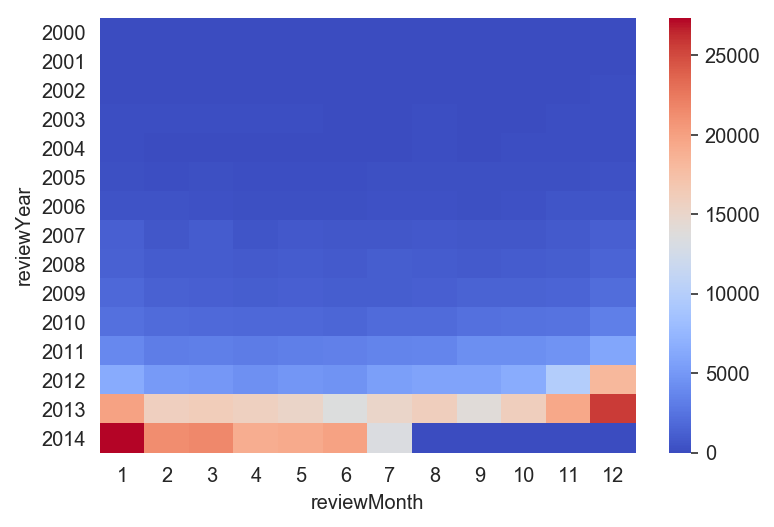

In [88]:
sns.heatmap(seasonality, cmap='coolwarm')

In [89]:
seasonality_perc = seasonality.copy()
seasonality_perc['All'] = seasonality[seasonality.columns].sum(axis=1)

In [90]:
seasonality_perc2 = seasonality_perc.div(seasonality_perc.iloc[:,-1], axis=0)
seasonality_perc2

reviewMonth,1,2,3,4,5,6,7,8,9,10,11,12,All
reviewYear,,,,,,,,,,,,,
2000,0.000000,0.000000,0.000000,0.000000,0.207627,0.110169,0.101695,0.076271,0.080508,0.097458,0.148305,0.177966,1.0
2001,0.064103,0.057692,0.085470,0.089744,0.059829,0.070513,0.057692,0.083333,0.091880,0.100427,0.145299,0.094017,1.0
2002,0.062331,0.048780,0.047425,0.048780,0.056911,0.054201,0.081301,0.100271,0.096206,0.098916,0.132791,0.172087,1.0
2003,0.104590,0.082769,0.097818,0.088789,0.082017,0.062453,0.075997,0.091798,0.043642,0.074492,0.092551,0.103085,1.0
2004,0.093520,0.069956,0.069956,0.058174,0.050810,0.071429,0.074374,0.084683,0.078056,0.102356,0.112666,0.134021,1.0
2005,0.085900,0.066051,0.077344,0.054073,0.057153,0.045859,0.074949,0.095825,0.098220,0.103696,0.103012,0.137919,1.0
2006,0.098371,0.101121,0.088005,0.055638,0.053522,0.063465,0.089063,0.090332,0.051830,0.074254,0.113603,0.120795,1.0
2007,0.122034,0.073975,0.097210,0.056201,0.081521,0.071989,0.072187,0.076457,0.071691,0.072783,0.085394,0.118558,1.0
2008,0.104066,0.080854,0.077504,0.071429,0.075791,0.074778,0.083424,0.077816,0.070026,0.079140,0.085216,0.119956,1.0


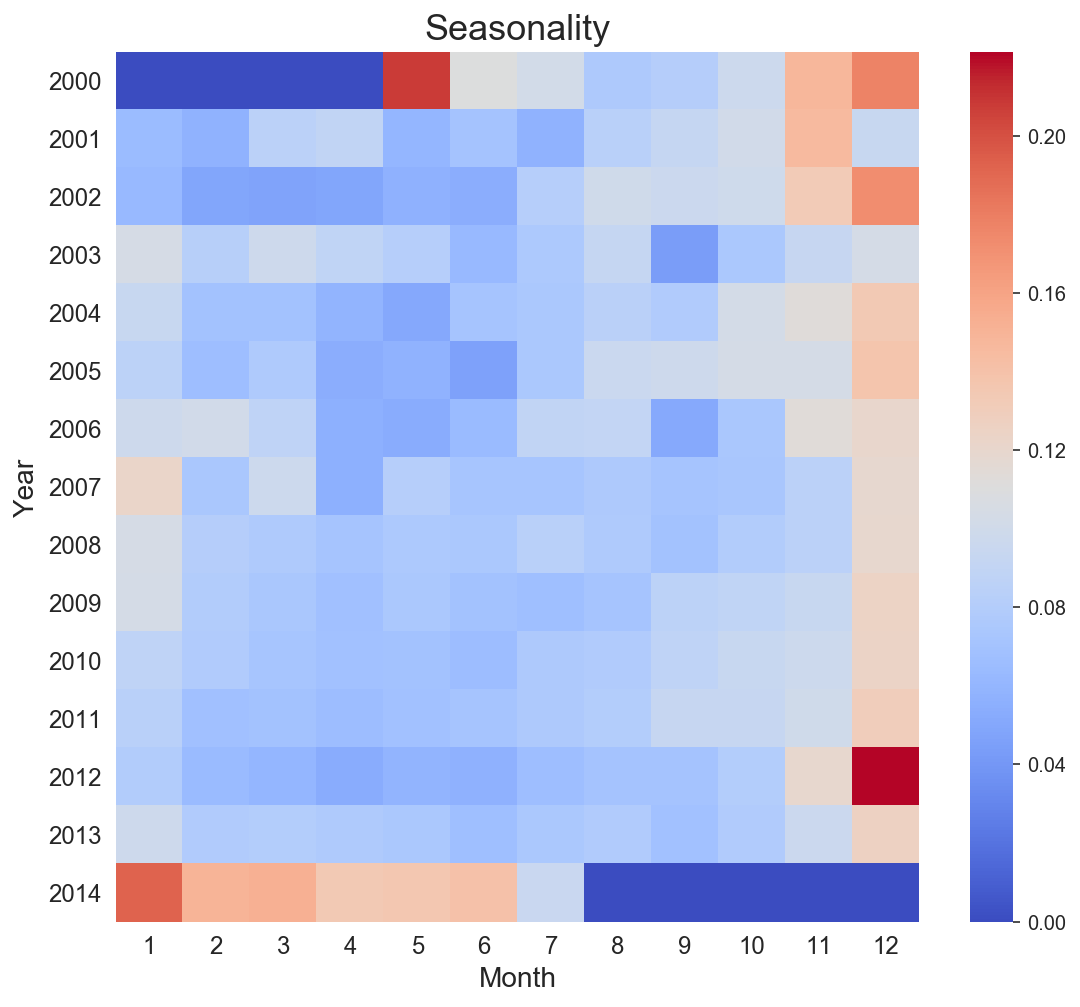

In [91]:
plt.figure(figsize=(9, 8))

sns.heatmap(seasonality_perc2.drop('All', axis=1), cmap='coolwarm')
plt.title('Seasonality', fontsize=18)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Year', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

plt.show()

#### Setting Train-Test-Split

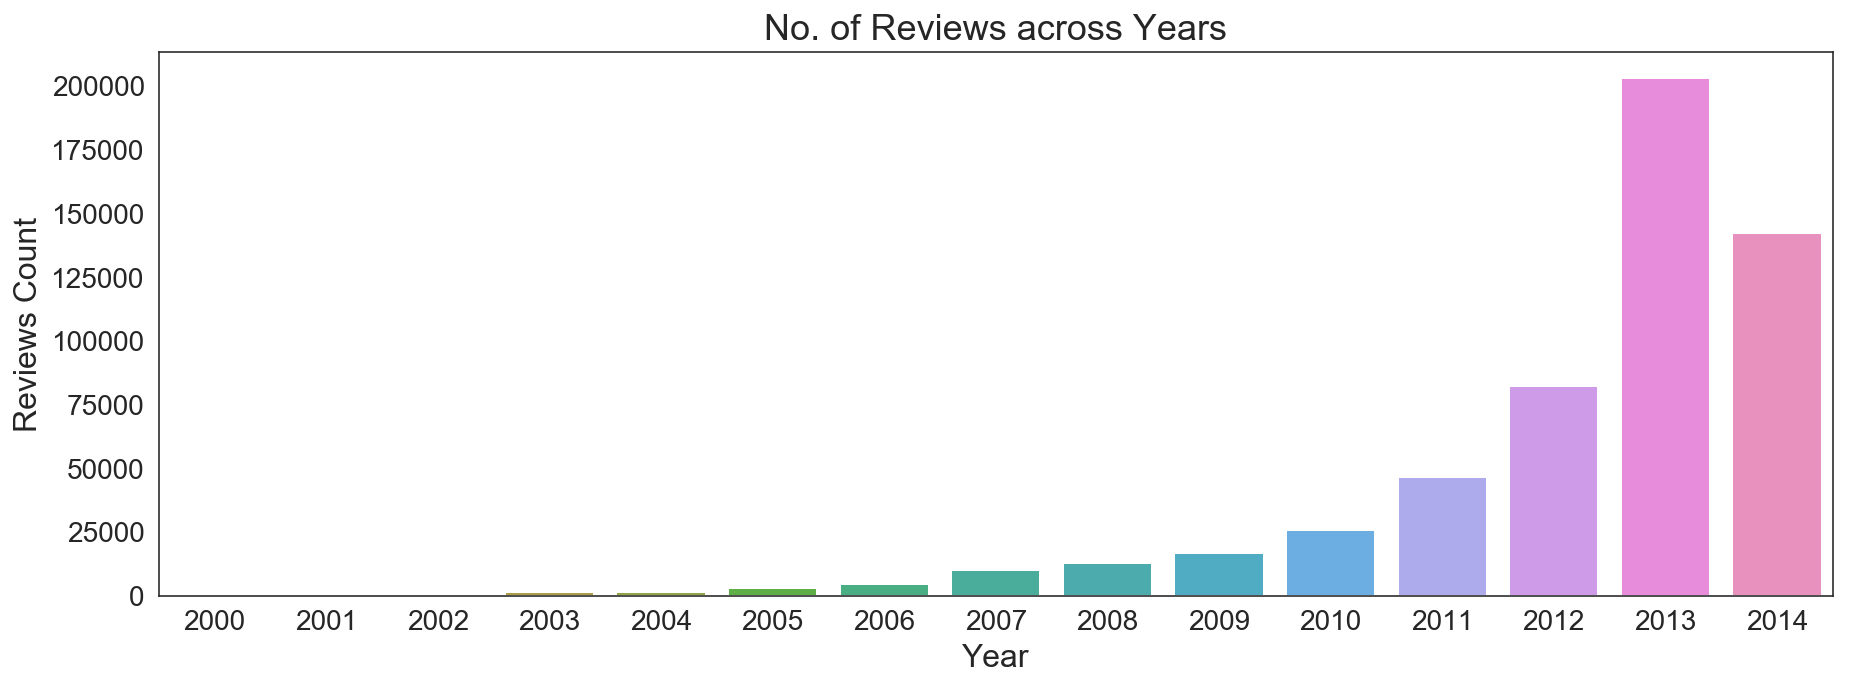

In [92]:
# train on 2013, test on 2014?
plt.figure(figsize=(15,5))
sns.countplot('reviewYear',data=df)

plt.title('No. of Reviews across Years', fontsize=18)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Reviews Count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [77]:
df['reviewTime'].max()

Timestamp('2014-07-23 00:00:00')

In [93]:
# get 2014 set of users, and pre-2014 set of users, see if there are overlaps

In [94]:
reviewers_2014 = set(df[df['reviewYear']==2014]['asin'])

In [95]:
reviewers_bef2014 = set(df[df['reviewYear']!=2014]['asin'])

In [96]:
print(len(reviewers_2014))
print(len(reviewers_bef2014))

21904
27348


In [97]:
yr_first_review = df.groupby('reviewerID')[['reviewYear']].min()
len(yr_first_review[yr_first_review['reviewYear']==2014])

4588

Of the 21,904 unique reviewers in 2014, 4,588 of them were new in 2014 <br>
_do I remove these 4,588?_

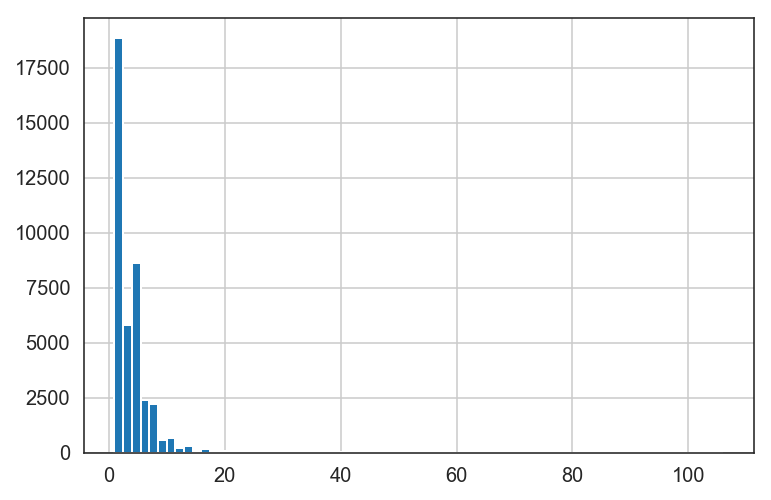

In [98]:
df[df['reviewYear']==2014].groupby('reviewerID')['overall'].count().hist(bins=70)

In [99]:
# get train test split
df_2014 = df[df['reviewYear']==2014]
df_pre2014 = df[df['reviewYear']!=2014]

# Modelling

### Attempt 2:
- Following Research Paper
- Use all 5-core data

#### Baseline Model: Predicting with mean/median

In [100]:
mean_score = df['overall'].mean()
median_score = df['overall'].median()

print('Mean Score: ', mean_score)
print('Median Score: ', median_score)

Mean Score:  4.316655247044493
Median Score:  5.0


In [101]:
from sklearn.metrics import mean_squared_error

In [102]:
df['overall'].shape

(551682,)

In [103]:
mean_array = np.full(df['overall'].shape, mean_score)
median_array = np.full(df['overall'].shape, median_score)

In [104]:
print('Mean RMSE: %.3f' % np.sqrt(mean_squared_error(df['overall'],mean_array)))
print('Median RMSE: %.3f' % np.sqrt(mean_squared_error(df['overall'],median_array)))

Mean RMSE: 1.111
Median RMSE: 1.304


#### Baseline Model with TTS

In [105]:
mean_score = df_pre2014['overall'].mean()
median_score = df_pre2014['overall'].median()

print('Mean Score: ', mean_score)
print('Median Score: ', median_score)

Mean Score:  4.290700514358566
Median Score:  5.0


In [106]:
mean_array = np.full(df_pre2014['overall'].shape, mean_score)
median_array = np.full(df_pre2014['overall'].shape, median_score)

print('Mean RMSE: %.3f' % np.sqrt(mean_squared_error(df_pre2014['overall'],mean_array)))
print('Median RMSE: %.3f' % np.sqrt(mean_squared_error(df_pre2014['overall'],median_array)))

Mean RMSE: 1.131
Median RMSE: 1.335


_testing cosine similarity by hand_

In [107]:
M = np.asarray([[3,7,4,9,9,7], 
                [7,0,5,3,8,8],
               [7,5,5,0,8,4],
               [5,6,8,5,9,8],
               [5,8,8,8,10,9],
               [7,7,0,4,7,8]])
M=pd.DataFrame(M)

In [108]:
np.dot(M.loc[0],M.loc[1])

196

In [109]:
np.linalg.norm(M.loc[0])*np.linalg.norm(M.loc[1])

245.22438704174593

In [110]:
196/245.22438704174593

0.7992679780524187

#### 1st Iteration: Unweighted & Uncentered Cosine Similarity

User-User similarity

In [111]:
# # get utility matrix (all data)
# %time utility_matrix = df_pre2014.pivot_table(values='overall',index='reviewerID',columns='asin')

# utility_matrix.fillna(0,inplace=True)

# from sklearn.metrics import pairwise_distances

# cosine_sim = 1 - pairwise_distances(utility_matrix, metric='cosine')
# cosine_sim = pd.DataFrame(cosine_sim, columns=utility_matrix.index, index=utility_matrix.index)

Full utility matrix fail, is taking damn long to process

In [112]:
# taking people with more than 30 reviews
df_30 = df[df['reviews_count']>=30]

In [113]:
df_30_pre2014 = df_30[df_30['reviewYear']!=2014]
df_30_2014 = df_30[df_30['reviewYear']==2014]

In [114]:
utility_matrix = df_30_pre2014.pivot_table(values='overall',index='reviewerID',columns='asin')

In [115]:
empty_cells = utility_matrix.isnull().sum().sum()
empty_cells

print('% of empty cells: {}'.format(empty_cells/np.product(utility_matrix.shape)))

# lulz
(1-0.9972270090971151)*100

% of empty cells: 0.9972270090971151


0.2772990902884853

In [116]:
utility_matrix.fillna(0, inplace=True)

In [117]:
from sklearn.metrics import pairwise_distances

In [118]:
cosine_sim = 1 - pairwise_distances(utility_matrix, metric='cosine')
cosine_sim = pd.DataFrame(cosine_sim, columns=utility_matrix.index, index=utility_matrix.index)
cosine_sim.head()

reviewerID,A100UD67AHFODS,A100WO06OQR8BQ,A1027WM3PXKVMR,A10AFVU66A79Y1,A10FL3TBQ7TI48,A10T7C2Y6O3MO2,A10Y058K7B96C6,A10ZBR6O8S8OCY,A10ZFE6YE0UHW8,A1115ST6F5CWYP,...,AYQQOW0VR0YF5,AYW1TGDCP2OK6,AYWUHB7N8XGZQ,AZ4EUUJVC8358,AZ4T61QUJHA9E,AZ8XSDMIX04VJ,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZV26LP92E6WU,AZV2U6GU5QA6C
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,1.000000,0.02466,0.000000,0.000000,0.035607,0.000000,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.028743,0.000000
A100WO06OQR8BQ,0.024660,1.00000,0.000000,0.000000,0.000000,0.017883,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.0,0.029058,0.0,0.026751,0.0,0.026642,0.000000,0.035909
A1027WM3PXKVMR,0.000000,0.00000,1.000000,0.040144,0.000000,0.000000,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.0,0.000000,0.0,0.045512,0.0,0.000000,0.000000,0.000000
A10AFVU66A79Y1,0.000000,0.00000,0.040144,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,...,0.0,0.091405,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
A10FL3TBQ7TI48,0.035607,0.00000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.02119,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000


In [119]:
cosine_sim.loc['A1ZH5ULI4SBO48'].sort_values(ascending=False)

reviewerID
A1ZH5ULI4SBO48    1.000000
A3BFDEBT5IV4UN    0.084720
A231LBC8EGPO5L    0.080584
AG6TX1ZJHLMO7     0.075603
A10ZBR6O8S8OCY    0.067993
A1W4F91DH3XPB2    0.065848
A3R7RE5O61M112    0.063661
A2OQG48HWD6L75    0.060936
A2C652Z72ZMFG5    0.059377
A1RRMZKOMZ2M7J    0.056557
AOQ2IB802NXAQ     0.056236
A1MZL91Z44RN06    0.055866
A10ZFE6YE0UHW8    0.053642
A1FK14ZCV3B1RA    0.053143
A2503LT8PZIHAD    0.052416
ADEZOPMPKK146     0.050660
A28HVL8ZZJEH21    0.048710
A1PTBXZG04GT29    0.047841
A2ZOQB9URMPUZK    0.046521
A39LRLKACX89IP    0.046201
A2L42QEWR77PKZ    0.045800
AB5X63CW9O0R6     0.045365
A3VBXQKRM7A4JR    0.044412
A3OXHLG6DIBRW8    0.044402
ALQ4USPEQ9L5N     0.044372
AYB8XLKTYMTTX     0.044292
A30JPZ9TZ7I61U    0.042708
A1TPW86OHXTXFC    0.042376
A22I55P15NSAOX    0.042012
A17SZZO9LM3WYC    0.041910
                    ...   
A3BKNXX8QFIXIV    0.000000
A3G7BEJJCPD6DS    0.000000
A3GF0NIB9U6VVH    0.000000
A3GFK7F5IUF60X    0.000000
A3IV701XFS5COA    0.000000
A3JYX9GGUTDVIG   

In [120]:
cosine_sim.loc['A1ZH5ULI4SBO48',['A10AFVU66A79Y1','ATTK7J5JWVDYD']]

reviewerID
A10AFVU66A79Y1    0.037087
ATTK7J5JWVDYD     0.000000
Name: A1ZH5ULI4SBO48, dtype: float64

In [121]:
# find k similar users given user_id that have also bought product

In [122]:
def predict_rating(reviewerID, itemID, k=3, matrix=cosine_sim, train_df=df_30_pre2014, test_df=df_30_2014):
    
    try: 
        # get list of users who have reviewed item
        reviewers = train_df[train_df['asin']==itemID]['reviewerID']

        # narrow cosine_sim list to this list of users
        reviewers_cosine_sim = matrix.loc[reviewerID,reviewers].sort_values(ascending=False)

        # get the top k
        k_most_similar_users = reviewers_cosine_sim[:k].index

        # find their ratings and average it
        predicted_rating = train_df[(train_df['reviewerID'].isin(k_most_similar_users)) & 
                                    (train_df['asin']==itemID)]['overall'].mean()

        return predicted_rating
    
    except KeyError: # for userIDs that only have reviews in 2014
        
        return train_df['overall'].mean()

In [123]:
#df_30_2014[df_30_2014['reviewerID']=='A2ODY6CW8YEX51']

In [124]:
predict_rating('A2ODY6CW8YEX51','B00004OCIP',3,cosine_sim,df_30_pre2014, df_30_2014)

4.358979190782566

In [125]:
preds_1 = df_30_2014[['reviewerID','asin','overall']].reset_index(drop=True)
preds_1

,reviewerID,asin,overall
0,A1ZH5ULI4SBO48,B0006TJ7HM,2.0
1,A1ZH5ULI4SBO48,B0009ONZ8G,3.0
2,A1ZH5ULI4SBO48,B000B7PNGS,1.0
3,A1ZH5ULI4SBO48,B000MM5EQG,5.0
4,A1ZH5ULI4SBO48,B00840EG5S,3.0
5,A1ZH5ULI4SBO48,B00876CQ8S,3.0
6,A1ZH5ULI4SBO48,B00E0FKQPA,5.0
7,A1ZH5ULI4SBO48,B00G3BS6LK,5.0
8,A1ZH5ULI4SBO48,B00HVOGM0U,4.0
9,A1ZH5ULI4SBO48,B00I937QEI,4.0


In [126]:
preds_1['predicted ratings'] = preds_1.apply(lambda x: predict_rating(x['reviewerID'],x['asin']),axis=1)

In [127]:
preds_1.head(20)

,reviewerID,asin,overall,predicted ratings
0,A1ZH5ULI4SBO48,B0006TJ7HM,2.0,4.333333
1,A1ZH5ULI4SBO48,B0009ONZ8G,3.0,4.333333
2,A1ZH5ULI4SBO48,B000B7PNGS,1.0,4.666667
3,A1ZH5ULI4SBO48,B000MM5EQG,5.0,4.333333
4,A1ZH5ULI4SBO48,B00840EG5S,3.0,NaN
5,A1ZH5ULI4SBO48,B00876CQ8S,3.0,NaN
6,A1ZH5ULI4SBO48,B00E0FKQPA,5.0,NaN
7,A1ZH5ULI4SBO48,B00G3BS6LK,5.0,NaN
8,A1ZH5ULI4SBO48,B00HVOGM0U,4.0,NaN
9,A1ZH5ULI4SBO48,B00I937QEI,4.0,NaN


In [128]:
# nan is when the item was not bought before 2014 (item IDs only from 2014)
df_30_pre2014[df_30_pre2014['asin']=='B00840EG5S']

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewYear,reviews_count,review_len,reviewMonth


In [129]:
preds_1.fillna(df_30_pre2014['overall'].mean(),inplace=True)
preds_1

,reviewerID,asin,overall,predicted ratings
0,A1ZH5ULI4SBO48,B0006TJ7HM,2.0,4.333333
1,A1ZH5ULI4SBO48,B0009ONZ8G,3.0,4.333333
2,A1ZH5ULI4SBO48,B000B7PNGS,1.0,4.666667
3,A1ZH5ULI4SBO48,B000MM5EQG,5.0,4.333333
4,A1ZH5ULI4SBO48,B00840EG5S,3.0,4.358979
5,A1ZH5ULI4SBO48,B00876CQ8S,3.0,4.358979
6,A1ZH5ULI4SBO48,B00E0FKQPA,5.0,4.358979
7,A1ZH5ULI4SBO48,B00G3BS6LK,5.0,4.358979
8,A1ZH5ULI4SBO48,B00HVOGM0U,4.0,4.358979
9,A1ZH5ULI4SBO48,B00I937QEI,4.0,4.358979


In [130]:
print('Uncentered, Unweighted Cosine Similarity RMSE: %.3f' % 
      np.sqrt(mean_squared_error(preds_1['overall'],preds_1['predicted ratings'])))

Uncentered, Unweighted Cosine Similarity RMSE: 0.972


In [131]:
print('Mean RMSE: %.3f' % np.sqrt(mean_squared_error(df_pre2014['overall'],mean_array)))
print('Median RMSE: %.3f' % np.sqrt(mean_squared_error(df_pre2014['overall'],median_array)))

Mean RMSE: 1.131
Median RMSE: 1.335


heh, slight improvement with Uncentered and unweighted Cosine similarity in terms of RMSE

#### 2nd Iteration: Unweighted & Centered Cosine Similarity

In [132]:
utility_matrix.head()

asin,0615391206,0912696591,1567120709,1891747401,7802215811,B00000JGRP,B00000JGRQ,B00000JGRS,B00000JGRT,B00002N5FO,...,B00H5F3GRW,B00H7LOLT6,B00HCZ0X9Y,B00HNPNNLS,B00I9R232Y,B00JEL09BG,B00JYAEUGM,B00K75U6IE,B00K8FPSSG,B00KQJ42CW
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1027WM3PXKVMR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10FL3TBQ7TI48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# WRONK! For 0 values, leave it as 0 values, do NOT subtract the row mean off the 0 values

In [133]:
utility_matrix_centered = utility_matrix.sub(utility_matrix.mean(axis=1),axis=0)
utility_matrix_centered.head()

asin,0615391206,0912696591,1567120709,1891747401,7802215811,B00000JGRP,B00000JGRQ,B00000JGRS,B00000JGRT,B00002N5FO,...,B00H5F3GRW,B00H7LOLT6,B00HCZ0X9Y,B00HNPNNLS,B00I9R232Y,B00JEL09BG,B00JYAEUGM,B00K75U6IE,B00K8FPSSG,B00KQJ42CW
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,-0.011222,-0.011222,-0.011222,-0.011222,-0.011222,-0.011222,-0.011222,-0.011222,-0.011222,-0.011222,...,-0.011222,-0.011222,-0.011222,-0.011222,-0.011222,-0.011222,-0.011222,-0.011222,4.988778,-0.011222
A100WO06OQR8BQ,-0.014175,-0.014175,-0.014175,-0.014175,-0.014175,-0.014175,-0.014175,-0.014175,-0.014175,-0.014175,...,-0.014175,-0.014175,-0.014175,-0.014175,-0.014175,-0.014175,-0.014175,-0.014175,-0.014175,-0.014175
A1027WM3PXKVMR,-0.005242,-0.005242,-0.005242,-0.005242,-0.005242,-0.005242,-0.005242,-0.005242,-0.005242,-0.005242,...,-0.005242,-0.005242,-0.005242,-0.005242,-0.005242,-0.005242,-0.005242,-0.005242,-0.005242,-0.005242
A10AFVU66A79Y1,-0.012625,-0.012625,-0.012625,-0.012625,-0.012625,-0.012625,-0.012625,-0.012625,-0.012625,-0.012625,...,-0.012625,-0.012625,-0.012625,-0.012625,-0.012625,-0.012625,-0.012625,-0.012625,-0.012625,-0.012625
A10FL3TBQ7TI48,-0.010853,-0.010853,-0.010853,-0.010853,-0.010853,-0.010853,-0.010853,-0.010853,-0.010853,-0.010853,...,-0.010853,-0.010853,-0.010853,-0.010853,-0.010853,-0.010853,-0.010853,-0.010853,-0.010853,-0.010853


In [134]:
cosine_sim = 1 - pairwise_distances(utility_matrix_centered, metric='cosine')
cosine_sim = pd.DataFrame(cosine_sim, columns=utility_matrix_centered.index, index=utility_matrix_centered.index)
cosine_sim.head()

reviewerID,A100UD67AHFODS,A100WO06OQR8BQ,A1027WM3PXKVMR,A10AFVU66A79Y1,A10FL3TBQ7TI48,A10T7C2Y6O3MO2,A10Y058K7B96C6,A10ZBR6O8S8OCY,A10ZFE6YE0UHW8,A1115ST6F5CWYP,...,AYQQOW0VR0YF5,AYW1TGDCP2OK6,AYWUHB7N8XGZQ,AZ4EUUJVC8358,AZ4T61QUJHA9E,AZ8XSDMIX04VJ,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZV26LP92E6WU,AZV2U6GU5QA6C
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,1.000000,0.022063,-0.001674,-0.002535,0.033336,-0.002153,-0.002837,-0.002242,-0.002102,-0.003184,...,-0.002469,-0.002680,-0.002026,-0.002527,-0.002329,-0.002744,-0.002172,-0.002444,0.026105,-0.002075
A100WO06OQR8BQ,0.022063,1.000000,-0.001894,-0.002868,-0.002664,0.015492,-0.003209,-0.002536,-0.002378,-0.003602,...,-0.002792,-0.003032,-0.002292,0.026283,-0.002635,0.023730,-0.002457,0.023952,-0.003073,0.033648
A1027WM3PXKVMR,-0.001674,-0.001894,1.000000,0.038420,-0.001674,-0.001531,-0.002017,-0.001594,-0.001495,-0.002264,...,-0.001755,-0.001906,-0.001441,-0.001797,-0.001656,0.043661,-0.001544,-0.001738,-0.001932,-0.001475
A10AFVU66A79Y1,-0.002535,-0.002868,0.038420,1.000000,-0.002536,-0.002318,-0.003055,-0.002414,-0.002264,-0.003428,...,-0.002658,0.088784,-0.002182,-0.002721,-0.002508,-0.002954,-0.002339,-0.002631,-0.002925,-0.002234
A10FL3TBQ7TI48,0.033336,-0.002664,-0.001674,-0.002536,1.000000,-0.002153,-0.002837,-0.002242,-0.002102,0.018076,...,-0.002469,-0.002680,-0.002026,-0.002527,-0.002329,-0.002744,-0.002172,-0.002444,-0.002717,-0.002075


In [135]:
preds_2 = df_30_2014[['reviewerID','asin','overall']].reset_index(drop=True)
preds_2.head()

,reviewerID,asin,overall
0,A1ZH5ULI4SBO48,B0006TJ7HM,2.0
1,A1ZH5ULI4SBO48,B0009ONZ8G,3.0
2,A1ZH5ULI4SBO48,B000B7PNGS,1.0
3,A1ZH5ULI4SBO48,B000MM5EQG,5.0
4,A1ZH5ULI4SBO48,B00840EG5S,3.0


In [136]:
preds_2['predicted ratings'] = preds_2.apply(lambda x: predict_rating(x['reviewerID'],x['asin']),axis=1)

In [137]:
preds_2.head(20)

,reviewerID,asin,overall,predicted ratings
0,A1ZH5ULI4SBO48,B0006TJ7HM,2.0,4.333333
1,A1ZH5ULI4SBO48,B0009ONZ8G,3.0,4.333333
2,A1ZH5ULI4SBO48,B000B7PNGS,1.0,4.666667
3,A1ZH5ULI4SBO48,B000MM5EQG,5.0,4.333333
4,A1ZH5ULI4SBO48,B00840EG5S,3.0,NaN
5,A1ZH5ULI4SBO48,B00876CQ8S,3.0,NaN
6,A1ZH5ULI4SBO48,B00E0FKQPA,5.0,NaN
7,A1ZH5ULI4SBO48,B00G3BS6LK,5.0,NaN
8,A1ZH5ULI4SBO48,B00HVOGM0U,4.0,NaN
9,A1ZH5ULI4SBO48,B00I937QEI,4.0,NaN


In [138]:
preds_2.fillna(df_30_pre2014['overall'].mean(),inplace=True)
preds_2

,reviewerID,asin,overall,predicted ratings
0,A1ZH5ULI4SBO48,B0006TJ7HM,2.0,4.333333
1,A1ZH5ULI4SBO48,B0009ONZ8G,3.0,4.333333
2,A1ZH5ULI4SBO48,B000B7PNGS,1.0,4.666667
3,A1ZH5ULI4SBO48,B000MM5EQG,5.0,4.333333
4,A1ZH5ULI4SBO48,B00840EG5S,3.0,4.358979
5,A1ZH5ULI4SBO48,B00876CQ8S,3.0,4.358979
6,A1ZH5ULI4SBO48,B00E0FKQPA,5.0,4.358979
7,A1ZH5ULI4SBO48,B00G3BS6LK,5.0,4.358979
8,A1ZH5ULI4SBO48,B00HVOGM0U,4.0,4.358979
9,A1ZH5ULI4SBO48,B00I937QEI,4.0,4.358979


In [139]:
print('Unweighted Cosine Similarity RMSE: %.3f' % 
      np.sqrt(mean_squared_error(preds_2['overall'],preds_2['predicted ratings'])))

Unweighted Cosine Similarity RMSE: 0.972


In [140]:
# no difference :( is it because the matrix is too sparse?

#### 3rd iteration: Weighted cosine similarities

In [141]:
# how to dooooo

#### use NLP on reviews to predict ratings

#### Topic modelling on reviews
- to get the subject of the reviews? no need labelled data. Topic modelling is unsupervised

### Attempt 1: 
Narrow down dataset to users who have reviewed 10 or more times<br>
Unique Users: 13694 <br>
Unique Products: 27292 <br>

In [142]:
df_10 = df[df['reviews_count']>=10]

In [143]:
list(df_10['reviewerName'].unique())

['mirasreviews',
 'M. Johnson "Tea Lover"',
 'S. G. "s.g."',
 'Deborah Verlen "Deborah"',
 'NYCPickyMom',
 'A. Lenz',
 'Alli09',
 'Amazon Customer',
 'Barbara "barbara11td"',
 nan,
 'Cardona "Cosmopolitana"',
 'Cathy',
 'David Kahle "Super Chef"',
 'Elisos',
 'Ellen T.',
 'Eve UrAlly "Ur Ally"',
 'F. T "Shop lover"',
 'iMinmei',
 'Jackie K',
 'JBo',
 'J-J-J-Jinx!',
 'Joann',
 'KARichards',
 'lissasaves',
 'lovetodecorate',
 'L. Tomk "Shopping Fool"',
 'Marie Arlene Smith',
 'M. Tennant',
 'Picky CO Mom',
 'Sara12345',
 'Shannon L. Toohey',
 'stefanj',
 'strongbear',
 'tachi1 "tachi1"',
 'Winter',
 'Bettie',
 'Erin Boyle',
 'K. Murray',
 'Mr.Bill',
 'Gary A. Olson',
 'glory',
 'justsomeguy',
 'R. W. Milyard "GearJunky"',
 'Stephen R. Walker',
 't49y',
 'Diana and Bob',
 'Dr. Bojan Tunguz',
 'J. Paine "JRBX"',
 'MF',
 'M. Karazim',
 'RMS "RMS"',
 'Anna',
 'Natalia Murataeva "Natasha"',
 'Annette',
 "Kira's mom",
 'Harry',
 'R. Edwards "quality and value sleuth"',
 'TripleJ',
 'Amazon Cus

In [144]:
# over how many years were the reviews written?
df_10[df_10['reviewerName']=='M. Johnson "Tea Lover"'].groupby('reviewYear')[['asin','reviewerName']].count()

,asin,reviewerName
reviewYear,,
2003,1,1
2006,1,1
2007,1,1
2008,3,3
2009,3,3
2011,8,8
2012,1,1
2013,2,2
2014,1,1


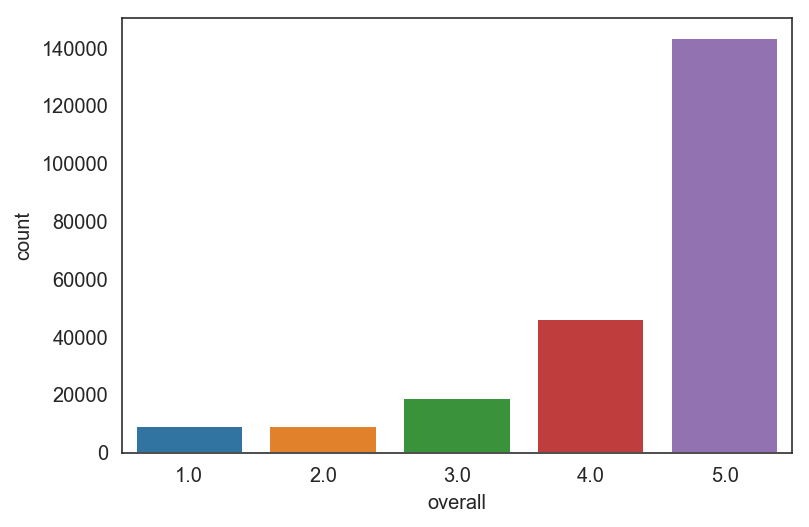

In [145]:
sns.countplot(df_10['overall'])

In [146]:
# getting rid of unnecessary rows:
df_10_utilmat = df_10.copy()
df_10_utilmat = df_10_utilmat[['reviewerID','asin','overall']]
df_10_utilmat.head()

,reviewerID,asin,overall
2,A3UPYGJKZ0XTU4,0615391206,4.0
13571,A3UPYGJKZ0XTU4,B00004SGE2,5.0
13644,A3UPYGJKZ0XTU4,B00004SGF1,5.0
24540,A3UPYGJKZ0XTU4,B00005AL5M,5.0
24762,A3UPYGJKZ0XTU4,B00005AL8N,3.0


In [147]:
df_10_utilmat = df_10_utilmat.pivot_table(values='overall',index='reviewerID',columns='asin')

In [148]:
df_10_utilmat.head()

asin,0615391206,0689027818,0912696591,1223070743,1567120709,1891747401,1983475912,2042037265,7213035835,7502151168,...,B00KY3EZAE,B00KY4Z1I8,B00L5NO3I6,B00L8FDIZU,B00L8FQZ3M,B00L8HA5L8,B00L9KOZBK,B00LAI4UYS,B00LB18EKK,B00LBFUU12
reviewerID,,,,,,,,,,,,,,,,,,,,,
A00473363TJ8YSZ3YAGG9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00593903MCE5GXTAGGNL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A037357115LCU92V2R0YR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0678500JUN3N7KUG4PS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0718784TOWF9DX1DOFD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
empty_cells = df_10_utilmat.isnull().sum().sum()
empty_cells

373510145

In [150]:
df_10_utilmat.shape

(13694, 27292)

In [151]:
print('% of empty cells: {}'.format(empty_cells/np.product(df_10_utilmat.shape)))

% of empty cells: 0.9993939502555821


In [152]:
# lulz
(1-0.999393950)*100

0.06060500000000246

In [153]:
df_10_jacaard = df_10_utilmat.fillna(0)

In [ ]:
# from sklearn.metrics.pairwise import pairwise_distances

# jac_sim = 1 - pairwise_distances(df_10_jacaard.T, metric = "hamming")
# # optionally convert it to a DataFrame
# jac_sim = pd.DataFrame(jac_sim, index=df_10_jacaard.columns, columns=df_10_jacaard.columns)

# jac_sim

# jac_sim_user = 1 - pairwise_distances(df_10_jacaard, metric = "hamming")
# # optionally convert it to a DataFrame
# jac_sim_user = pd.DataFrame(jac_sim_user, index=df_10_jacaard.index, columns=df_10_jacaard.index)

# jac_sim_user

# #So Jacaard similarity is saying that all the users are similar to each other - but is probably because they all did not buy many products

# #### Trying with centered cosine

# from sklearn.metrics.pairwise import cosine_similarity

# df_10_cntrd_cossim = df_10_utilmat.fillna(0)
# df_10_cntrd_cossim = df_10_cntrd_cossim.sub(df_10_cntrd_cossim.mean(axis=1),axis=0)
# df_10_cntrd_cossim

# ctr_cossim_user = cosine_similarity(df_10_cntrd_cossim, dense_output=False)

# ctr_cossim_user = pd.DataFrame(ctr_cossim_user, index=df_10_cntrd_cossim.index, 
#                                columns=df_10_cntrd_cossim.index)
# ctr_cossim_user

# ctr_cossim_user.iloc[0].sort_values(ascending=False)

# df[df['reviewerID']=='A00473363TJ8YSZ3YAGG9']

# thomas_products = list(df[df['reviewerID']=='A00473363TJ8YSZ3YAGG9']['asin'])
# thomas_products

# brown_products = list(df[df['reviewerID']=='A2A6IKDJ456ZGY']['asin'])

# for product in brown_products:
#     print(product, product in thomas_products)

# # supposedly similar
# df[df['reviewerID']=='A2A6IKDJ456ZGY']

# joanna_products = list(df[df['reviewerID']=='A1IU7S4HCK1XK0']['asin'])

# for product in joanna_products:
#     print(product, product in thomas_products)

# # least similar
# df[df['reviewerID']=='A1IU7S4HCK1XK0']

# Feature Engineering / NLP

In [ ]:
# topic modelling
# pos tagging

In [ ]:
# clean up reviews text, to lower and strip punctuations

In [ ]:
import string
table = str.maketrans('','', string.punctuation)

In [ ]:
df_merge['reviews_cleaned'] = df_merge['reviewText'].apply(lambda x: x.lower().translate(table))

In [ ]:
df_merge['reviews_cleaned'].head(2)

In [ ]:
from gensim import corpora, models, matutils
from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')

In [ ]:
stop_nltk = stopwords.words('English')
stop_sklearn = list(ENGLISH_STOP_WORDS)

In [ ]:
cvec = CountVectorizer(stop_words=stop_sklearn)
X = cvec.fit_transform(df_merge['reviews_cleaned'])

In [ ]:
len(cvec.vocabulary_.keys())

In [ ]:
frequency = defaultdict(int)

for review in df_merge['reviews_cleaned']:
    for token in review.split():
        frequency[token] += 1

In [ ]:
retained_tokens = [[token for token in text.split() if frequency[token] > 1 and token not in stop_sklearn] 
                   for text in df_merge['reviews_cleaned']]
retained_tokens

In [ ]:
dictionary = corpora.Dictionary(retained_tokens)
dictionary

In [ ]:
corpus = [dictionary.doc2bow(text) for text in retained_tokens]
corpus

In [ ]:
#lda = models.LdaModel(corpus, num_topics=5, passes =20, id2word=dictionary)

In [ ]:
# for topic in lda.print_topics(num_topics=3, num_words=5):
#     print(topic[1])
#     print(' ')

## 6 Nov attempt

In [ ]:
# # taking people with more than 30 reviews
# df_30 = df[df['reviews_count']>=30]

# df_30_pre2014 = df_30[df_30['reviewYear']!=2014]
# df_30_2014 = df_30[df_30['reviewYear']==2014]

# utility_matrix = df_30_pre2014.pivot_table(values='overall',index='reviewerID',columns='asin')

# utility_matrix.fillna(0, inplace=True)

# cosine_sim = 1 - pairwise_distances(utility_matrix, metric='cosine')
# cosine_sim = pd.DataFrame(cosine_sim, columns=utility_matrix.index, index=utility_matrix.index)
# cosine_sim.head()

In [188]:
reviewers = df_30_pre2014[df_30_pre2014['asin']=='B0006TJ7HM']['reviewerID']
reviewers

106799     ATTK7J5JWVDYD
106725    A353U0L2HAMSHV
106847    A1XHPYG3D2WVCM
106827    A2DPYMNI2HCIOI
106700     A6VPK7X53QNAQ
106807     AF7VAC7KSF3ZE
Name: reviewerID, dtype: object

In [190]:
cosine_sim.loc['A1ZH5ULI4SBO48', reviewers].sort_values(ascending=False)

reviewerID
A353U0L2HAMSHV    0.028591
A2DPYMNI2HCIOI    0.024954
AF7VAC7KSF3ZE    -0.001737
A1XHPYG3D2WVCM   -0.002214
A6VPK7X53QNAQ    -0.002427
ATTK7J5JWVDYD    -0.003479
Name: A1ZH5ULI4SBO48, dtype: float64

In [ ]:
A1ZH5ULI4SBO48	B0006TJ7HM

In [171]:
def predict_rating(reviewerID, itemID, k=3, matrix=cosine_sim, train_df=df_30_pre2014, test_df=df_30_2014):
    
    try: 
        # get list of users who have reviewed item
        reviewers = train_df[train_df['asin']==itemID]['reviewerID']

        # narrow cosine_sim list to this list of users
        reviewers_cosine_sim = matrix.loc[reviewerID,reviewers].sort_values(ascending=False)

        # get the top k
        k_most_similar_users = reviewers_cosine_sim[:k].index

        # find their ratings and average it
        predicted_rating = train_df[(train_df['reviewerID'].isin(k_most_similar_users)) & 
                                    (train_df['asin']==itemID)]['overall'].mean()

        return predicted_rating
    
    except KeyError: # for userIDs that only have reviews in 2014
        
        return train_df['overall'].mean()

In [123]:
#df_30_2014[df_30_2014['reviewerID']=='A2ODY6CW8YEX51']

In [172]:
predict_rating('A2ODY6CW8YEX51','B00004OCIP',3,cosine_sim,df_30_pre2014, df_30_2014)

4.358979190782566

In [125]:
preds_1 = df_30_2014[['reviewerID','asin','overall']].reset_index(drop=True)
preds_1

,reviewerID,asin,overall
0,A1ZH5ULI4SBO48,B0006TJ7HM,2.0
1,A1ZH5ULI4SBO48,B0009ONZ8G,3.0
2,A1ZH5ULI4SBO48,B000B7PNGS,1.0
3,A1ZH5ULI4SBO48,B000MM5EQG,5.0
4,A1ZH5ULI4SBO48,B00840EG5S,3.0
5,A1ZH5ULI4SBO48,B00876CQ8S,3.0
6,A1ZH5ULI4SBO48,B00E0FKQPA,5.0
7,A1ZH5ULI4SBO48,B00G3BS6LK,5.0
8,A1ZH5ULI4SBO48,B00HVOGM0U,4.0
9,A1ZH5ULI4SBO48,B00I937QEI,4.0


In [126]:
preds_1['predicted ratings'] = preds_1.apply(lambda x: predict_rating(x['reviewerID'],x['asin']),axis=1)

In [127]:
preds_1.head(20)

,reviewerID,asin,overall,predicted ratings
0,A1ZH5ULI4SBO48,B0006TJ7HM,2.0,4.333333
1,A1ZH5ULI4SBO48,B0009ONZ8G,3.0,4.333333
2,A1ZH5ULI4SBO48,B000B7PNGS,1.0,4.666667
3,A1ZH5ULI4SBO48,B000MM5EQG,5.0,4.333333
4,A1ZH5ULI4SBO48,B00840EG5S,3.0,NaN
5,A1ZH5ULI4SBO48,B00876CQ8S,3.0,NaN
6,A1ZH5ULI4SBO48,B00E0FKQPA,5.0,NaN
7,A1ZH5ULI4SBO48,B00G3BS6LK,5.0,NaN
8,A1ZH5ULI4SBO48,B00HVOGM0U,4.0,NaN
9,A1ZH5ULI4SBO48,B00I937QEI,4.0,NaN


In [128]:
# nan is when the item was not bought before 2014 (item IDs only from 2014)
df_30_pre2014[df_30_pre2014['asin']=='B00840EG5S']

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewYear,reviews_count,review_len,reviewMonth


In [129]:
preds_1.fillna(df_30_pre2014['overall'].mean(),inplace=True)
preds_1

,reviewerID,asin,overall,predicted ratings
0,A1ZH5ULI4SBO48,B0006TJ7HM,2.0,4.333333
1,A1ZH5ULI4SBO48,B0009ONZ8G,3.0,4.333333
2,A1ZH5ULI4SBO48,B000B7PNGS,1.0,4.666667
3,A1ZH5ULI4SBO48,B000MM5EQG,5.0,4.333333
4,A1ZH5ULI4SBO48,B00840EG5S,3.0,4.358979
5,A1ZH5ULI4SBO48,B00876CQ8S,3.0,4.358979
6,A1ZH5ULI4SBO48,B00E0FKQPA,5.0,4.358979
7,A1ZH5ULI4SBO48,B00G3BS6LK,5.0,4.358979
8,A1ZH5ULI4SBO48,B00HVOGM0U,4.0,4.358979
9,A1ZH5ULI4SBO48,B00I937QEI,4.0,4.358979


In [130]:
print('Uncentered, Unweighted Cosine Similarity RMSE: %.3f' % 
      np.sqrt(mean_squared_error(preds_1['overall'],preds_1['predicted ratings'])))

Uncentered, Unweighted Cosine Similarity RMSE: 0.972


In [131]:
print('Mean RMSE: %.3f' % np.sqrt(mean_squared_error(df_pre2014['overall'],mean_array)))
print('Median RMSE: %.3f' % np.sqrt(mean_squared_error(df_pre2014['overall'],median_array)))

Mean RMSE: 1.131
Median RMSE: 1.335
